# DEEP BEERS
## PLAYING WITH DEEP RECOMMENDATION ENGINES WITH KERAS

A few years ago, I scrapped with my friend <a href="https://twitter.com/alexvanacker">@alexvanacker</a> a beer rating website. I wanted at the time to test different recommendation algorithms. Full disclaimer, I am a bit of a data science beer geek.

More recently, I was advised to follow <a href="https://github.com/m2dsupsdlclass/lectures-labs">this excellent class</a> by Charles Ollion and Olivier Grisel, to learn more about some specific aspects of deep learning. When I came across the second lab on factorization machine and deep recommendations, I thought again about the old beer dataset and decided to give it a try. 

In the following blog post, I discus the different experiments I was able to run using keras. My code is more than heavily inspired by the class, so don't get alarmed if you detect obvious copy paste. 

This blog post is organised as follow: We start by introducing the data before explaining the separation between explicit and implicit recommendations. We start with the explicit one and describe the basic architectures before having some fun in grid searching it. Then we introduce more complex architectures to incoporate item metadata. Finally, we will describe implicit recommender system engine using the triplet loss. 

## The Data

### Ratings

Let's start by importing the scrapped data

In [1]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
beer_reviews = pd.read_csv('/data/pgutierrez/beer/beers_reviews_csv.csv.gz', sep=',')

In [3]:
''' no need to show '''

beer_reviews['user_id'] = beer_reviews['user_url'].map(lambda x : x.split(".")[1].replace('/',''))
beer_reviews['beer_id'] = beer_reviews['beer_url'].map(lambda x : x.split("/")[-2])

In [4]:
print beer_reviews.shape

(4563152, 9)


In [5]:
beer_reviews.head()

beer_url  score  \
0  http://www.beeradvocate.com//beer/profile/68/2...   4.00   
1  http://www.beeradvocate.com//beer/profile/68/2...   3.75   
2  http://www.beeradvocate.com//beer/profile/68/2...   3.75   
3  http://www.beeradvocate.com//beer/profile/68/2...   3.75   
4  http://www.beeradvocate.com//beer/profile/68/2...   4.00   

                                 user_url                 date review  rdev  \
0  /community/members/capnamerica.719306/  2014-09-07 01:16:00    NaN  -0.7   
1   /community/members/supermanny.817238/  2014-09-05 00:00:00    NaN  -6.9   
2       /community/members/mcnazz.719186/  2014-09-04 00:00:00    NaN  -6.9   
3  /community/members/zenbiscuits.699682/  2014-09-03 00:00:00    NaN  -6.9   
4         /community/members/jwal.799985/  2014-09-02 00:00:00    NaN  -0.7   

                   scrap_time user_id beer_id  
0  2014-09-13 04:37:56.471514  719306   24071  
1  2014-09-13 04:37:56.472023  817238   24071  
2  2014-09-13 04:37:56.472453  719186   24071  
3  2014-09-13 04:37:56.472876  699682   24071  
4  2014-09-13 04:37:56.473296  799985   24071

The dataset is composed 4.5 million reviews. It is composed of a beer id, a user id as well as a score between 1 and 5. For some entries, there is also a complete typed review, which I won't use in this blog post though it would be interesting to integrate it. 

Let's get an idea of what the rating distribution looks like.

In [6]:
beer_reviews["score"].describe()

count    4.563152e+06
mean     3.852421e+00
std      6.533483e-01
min      1.000000e+00
25%      3.500000e+00
50%      4.000000e+00
75%      4.250000e+00
max      5.000000e+00
Name: score, dtype: float64

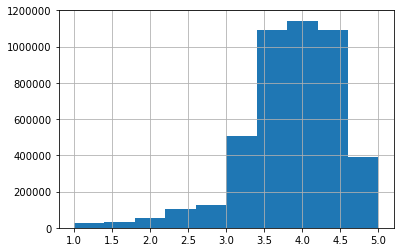

In [18]:
beer_reviews["score"].hist(bins=10)

The median is 4. This is very important because our data is skewed towards high ratings. This is a common bias in internet ratings, people tend to rate items or moovies that they liked, and rarely spend time to comment something they dislike or are indiferent to. This will have a huge impact on the way we model the recommendation problem. 

For the algorithm in keras to work, we need to remap all beers and users id to an interger between 0 and the total number of users / beers.

In [19]:
users = beer_reviews.user_id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}
beers = beer_reviews.beer_id.unique()
beer_map = {i:val for i,val in enumerate(beers)}
inverse_beer_map = {val:i for i,val in enumerate(beers)}

beer_reviews["user_id"] = beer_reviews["user_id"].map(inverse_user_map)
beer_reviews["old_id"] = beer_reviews["beer_id"] # copying for join with metadata
beer_reviews["beer_id"] = beer_reviews["beer_id"].map(inverse_beer_map)

print "We have %d users"%users.shape[0]
print "We have %d beers"%beers.shape[0] 

We have 91645 users
We have 78518 beers


Note the important number of users and reviews. This makes use ask the following questions: How many ratings do we have per beer ? Per user ? What is the corresponding distributions ?  

For the users we have:

In [20]:
users_nb = beer_reviews['user_id'].value_counts().reset_index()
users_nb.columns= ['user_id','nb_lines']
users_nb['nb_lines'].describe()

count    91645.000000
mean        49.791609
std        173.584107
min          1.000000
25%          1.000000
50%          4.000000
75%         23.000000
max       6311.000000
Name: nb_lines, dtype: float64

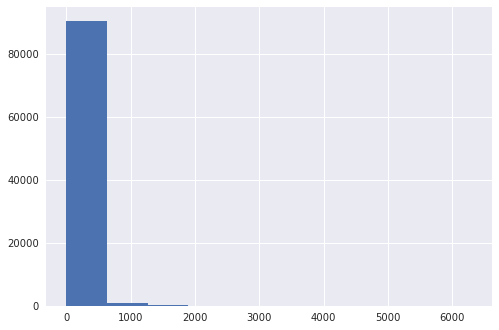

In [21]:
import seaborn
users_nb['nb_lines'].hist()

Off course the distribution is very skewed. With 50 % of people having done no more than 4 reviews... Whereas one got crazy with more than 6000 ratings! This has some implications: it means that for most people, we have few beers to characterize them, whereas for at least 25% we have more than 23 which is probably enough information to start generating good recommendations.

Now let's have a look at the items:

In [22]:
beers_nb = beer_reviews['old_id'].value_counts().reset_index()
beers_nb.columns= ['old_id','nb_lines']
beers_nb['nb_lines'].describe()

count    78518.000000
mean        58.115999
std        313.841229
min          1.000000
25%          2.000000
50%          5.000000
75%         18.000000
max      12450.000000
Name: nb_lines, dtype: float64

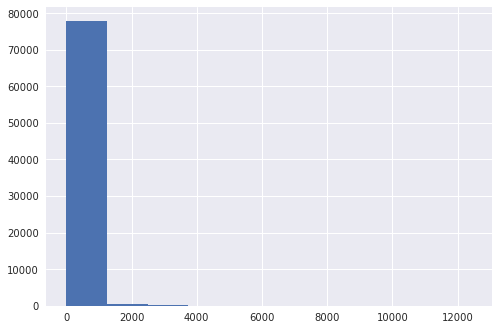

In [23]:
beers_nb['nb_lines'].hist()

Again, the distribution is very skewed with 50 % of the beers having 5 ratings or less. Even worse, 75% of beers have less than 18 ratings. Though it is normal for a user, we would assume that many users would generate more well spread beers. Let's have a look at the most rated beers. To do so, we need to load some other files containing the metadata.

In [ ]:
a = beer_reviews.dropna()[['beer_id','user_id','score','date','review']]

In [29]:
pd.set_option('display.max_colwidth', 100)
a.head(10)

beer_id  user_id  score                 date  \
15         0       15   4.10  2014-08-24 00:00:00   
24         0       24   4.00  2014-08-17 00:00:00   
67         0       67   3.89  2014-07-11 00:00:00   
69         0       69   4.21  2014-07-10 00:00:00   
72         0       72   3.63  2014-07-09 00:00:00   
76         0       76   4.13  2014-07-04 00:00:00   
96         0       96   3.51  2014-06-22 00:00:00   
155        0      155   3.76  2014-04-30 00:00:00   
167        0      167   4.43  2014-04-05 00:00:00   
179        0      179   4.15  2014-03-25 00:00:00   

                                                                                                  review  
15   I like this brewer and their Oyster Stout is a great session stout.  Perfect last beer of the ev...  
24   Pours a rich and dark. If it's not completely black it may as well be because there are no hues ...  
67   Appearance - Extremely dark, practically black . Okay head that lasted for a while and would slo...  
69   Vintage 2013 Appearance: It has a nice jet black color to it. It has a nice thick creamy tan hea...  
72   Appearance- poured from a glass into a guiness style glass. this shit is DARK. not much head, la...  
76   A - poured a one finger thick coffee-colored head into snifter that left a thin ring throughout....  
96   A: Dark brown to black. Forms a small head that dissappears to nothing. Swirling the beer in my ...  
155  2013 Vintage poured into DFH snifter.  A - inky black with mocha head S - lots of dark roasted m...  
167  A - 4 - Nice dark brown/black beer with a big mocha head on it, leaves nice lacing.  S - 4.25 - ...  
179  Vintage from 2010. 12oz poured into an oversized tulip. A - Black but not opaque. Small cap of t...

In [30]:
a.shape[0]/float(beer_reviews.shape[0])

0.2690559069695684

### Metadata

In [32]:
# beer metadata
all_info = pd.read_csv('/data/pgutierrez/beer/all_beer_info_complete.csv', sep=',') 
all_info['style'] = all_info['style'].fillna('no_data')
all_info['brewery_country'] = all_info['brewery_country'].fillna('no_data')
all_info['brewery'] = all_info['brewery'].fillna('no_data')
all_info['abv'] = pd.to_numeric(all_info['abv'],errors="coerce")
# often outliers in abv. check tactical nuclear pinguin or sink the bismark for examples. 
all_info['abv'] = all_info['abv'].fillna(all_info['abv'].median()) 
all_info['beer_id'] = all_info['id'].astype(str).map(inverse_beer_map) # remap

# adding the count 
beers_nb["old_id"] = beers_nb["old_id"].astype(int).values
all_info =  pd.merge(all_info,beers_nb,how='left',left_on='id',right_on='old_id')

# user metadata
users_infos = pd.read_csv('/data/pgutierrez/beer/users.csv.gz', sep=',') 
users_infos = users_infos.fillna('no_data')

In [43]:
#all_info['nb_lines']=all_info['nb_lines'].astype(int)
all_info.dropna().sample(10)[['name','style','brewery','brewery_country','nb_lines']]

name  \
49120      Old Guardian - Temecula Red Wine Barrel-Aged   
17330                                        Hop Common   
65111                            A Token Of Our Extreme   
24899  Great Lakes Deliverance - Pinot Noir Barrel Aged   
44402                        Mack-Daddy Chocolate Stout   
9204                  Gahan House Harvest Gold Pale Ale   
76094                                             Blond   
15277                                       Chili Lager   
29238                                  120 Shilling Ale   
71928                                Wing-Nut Brown Ale   

                                style                      brewery  \
49120             American Barleywine            Stone Brewing Co.   
17330  California Common / Steam Beer            Peekskill Brewery   
65111               American Wild Ale     Jackie O's Pub & Brewery   
24899          Saison / Farmhouse Ale          Great Lakes Brewery   
44402                  American Stout  Outer Banks Brewing Station   
9204          American Pale Ale (APA)              The Gahan House   
76094                Belgian Pale Ale               Brouwerij West   
15277                      Chile Beer         Tommyknocker Brewery   
29238          Scotch Ale / Wee Heavy             Rock Art Brewery   
71928              American Brown Ale    Kodiak Island Brewing Co.   

      brewery_country  nb_lines  
49120   United States       8.0  
17330   United States      83.0  
65111   United States      37.0  
24899          Canada       6.0  
44402   United States       8.0  
9204           Canada       7.0  
76094   United States      25.0  
15277   United States       8.0  
29238   United States       2.0  
71928   United States       2.0

In [50]:
users_infos[['user_id','join_date','occupation','location','birth_year']].head()

user_id     join_date occupation       location birth_year
0   724374  Mar 19, 2013    no_data       Maryland    no_data
1    72431  Mar 31, 2006    no_data       Maryland    no_data
2   697544   Oct 5, 2012   Engineer       Illinois    no_data
3    55882  Dec 20, 2005    no_data  Massachusetts    no_data
4   120748   Feb 4, 2007    no_data       Maryland    no_data

In [49]:
users_infos.columns

Index([u'user_id', u'user_name', u'join_date', u'occupation', u'location',
       u'gender', u'birth_year', u'content', u'home_page'],
      dtype='object')

Here are the most rated beers: 

In [52]:
all_info[['name','brewery_country','style','nb_lines']].sort('nb_lines',ascending=False).head(10)

name brewery_country  \
67170                        90 Minute IPA   United States   
59285             Founders Breakfast Stout   United States   
52528                      Two Hearted Ale   United States   
67171                      Pliny The Elder   United States   
67172                          Hopslam Ale   United States   
42703  Old Rasputin Russian Imperial Stout   United States   
67173                  Stone Ruination IPA   United States   
52530                          Sculpin IPA   United States   
52529                        60 Minute IPA   United States   
7265                Sierra Nevada Pale Ale   United States   

                                  style  nb_lines  
67170    American Double / Imperial IPA   12450.0  
59285  American Double / Imperial Stout   11694.0  
52528                      American IPA   10698.0  
67171    American Double / Imperial IPA   10467.0  
67172    American Double / Imperial IPA    9825.0  
42703            Russian Imperial Stout    9620.0  
67173    American Double / Imperial IPA    9400.0  
52530                      American IPA    9200.0  
52529                      American IPA    9017.0  
7265            American Pale Ale (APA)    8650.0

Though I know most of these beers, most of them do not seem very common to me. This is because of two bias: 
- Most of the people in the dataset come from the USA. Which explain that all these beers come from there. 
- Most of the people rating beers on this website have "beer geek" profile. Hence they will rate mostly beers they liked so you can expect the most rated beer to be quality beers easily findable. That's 90 minute IPA or Siera Nevada.

Let's have a look at the other metadata.

In [20]:
pd.set_option('display.max_colwidth', 30)
all_info.head()

style                           name  \
0  Baltic Porter          Gonzo Imperial Porter   
1  Baltic Porter                         3Beans   
2  Baltic Porter  Smuttynose Baltic Porter (...   
3  Baltic Porter                 Baltic Thunder   
4  Baltic Porter                    Dark Depths   

                           notes               brewery_location  \
0                    ABV varies.       Maryland , United States   
1  A Sixpoint & Friends jam s...       New York , United States   
2  35 IBU  2007 - 8.1% 2009 -...  New Hampshire , United States   
3         No notes at this time.   Pennsylvania , United States   
4  Combination between a Balt...  Massachusetts , United States   

            availability                      image_url         added_by  \
0               Rotating  http://cdn.beeradvocate.co...     BeerAdvocate   
1  Limited (brewed once)  http://cdn.beeradvocate.co...     BeerAdvocate   
2                 Winter  http://cdn.beeradvocate.co...  GratefulBeerGuy   
3             Year-round  http://cdn.beeradvocate.co...          akorsak   
4  Limited (brewed once)  http://cdn.beeradvocate.co...         Bierman9   

     abv                     beer_url_x     id   ...    brewery_postal_code  \
0   9.20  http://www.beeradvocate.co...  24071   ...                  21703   
1  10.00  http://www.beeradvocate.co...  88889   ...                  11231   
2   9.24  http://www.beeradvocate.co...  40674   ...                  03842   
3   8.50  http://www.beeradvocate.co...  40443   ...                  19335   
4   7.60  http://www.beeradvocate.co...  77234   ...             02130-2315   

               brewery_image_url       brewery_address   Macro Style  \
0  http://cdn.beeradvocate.co...  4607 Wedgewood Blvd.  English Ales   
1  http://cdn.beeradvocate.co...        40 Van Dyke St  English Ales   
2  http://cdn.beeradvocate.co...     105 Towle Farm Rd  English Ales   
3  http://cdn.beeradvocate.co...        420 Acorn Lane  English Ales   
4  http://cdn.beeradvocate.co...        30 Germania St  English Ales   

  Macro Style 2                     beer_url_y avg_rating beer_id   old_id  \
0           Ale  http://www.beeradvocate.co...   4.026906     0.0  24071.0   
1           Ale  http://www.beeradvocate.co...   4.029175     1.0  88889.0   
2           Ale  http://www.beeradvocate.co...   4.267594     2.0  40674.0   
3           Ale  http://www.beeradvocate.co...   3.866393     3.0  40443.0   
4           Ale  http://www.beeradvocate.co...   3.698539     4.0  77234.0   

  nb_lines  
0   2479.0  
1   1151.0  
2   1014.0  
3    890.0  
4    876.0  

[5 rows x 29 columns]

In the beer metadata we have it's name, the brewery, where the beer comes from, it's tyle and abv. I also computed a mean rating to get the top and worst beers. To give stable results, let's keep only beers rated more than 500 times.

In [54]:
all_info[all_info['nb_lines']>=500][["name",'style','avg_rating']].sort('avg_rating').head(5)

name                   style  avg_rating
491             Natural Light             Light Lager    1.673766
74533            Keystone Ice  American Adjunct Lager    1.699634
74522             Natural Ice  American Adjunct Lager    1.736900
504    Milwaukee's Best Light             Light Lager    1.785730
502                 Miller 64             Light Lager    1.788587

I have to say, I never tried any of these beers. You can't really find light beers in France. Let's have a look at the top ones:

In [56]:
all_info[all_info['nb_lines']>=500][["name",'style','avg_rating']].sort('avg_rating',ascending=False).head(5)

name  \
59364  Hunahpu's Imperial Stout - Double Barrel Aged   
67174                                   Heady Topper   
42741     Bourbon Barrel Aged Vanilla Bean Dark Lord   
59375                            Barrel-Aged Abraxas   
67345                                       King Sue   

                                  style  avg_rating  
59364  American Double / Imperial Stout    4.780888  
67174    American Double / Imperial IPA    4.731133  
42741            Russian Imperial Stout    4.726511  
59375  American Double / Imperial Stout    4.716880  
67345    American Double / Imperial IPA    4.704760

I have to say, I have no idea what are these beers. This may be because the best beers are probably craft beers and hence less well spread. Let's go for beers rated more than 10000 times to see what we get.

In [61]:
all_info[all_info['nb_lines']>=5000][["name",'style','avg_rating']].sort('avg_rating',ascending=False).head(5)

name  \
67174                             Heady Topper   
67171                          Pliny The Elder   
59286  Founders KBS (Kentucky Breakfast Stout)   
7266                               Zombie Dust   
59287               Bourbon County Brand Stout   

                                  style  avg_rating  
67174    American Double / Imperial IPA    4.731133  
67171    American Double / Imperial IPA    4.650610  
59286  American Double / Imperial Stout    4.625228  
7266            American Pale Ale (APA)    4.616031  
59287  American Double / Imperial Stout    4.583207

Now, I do remember filling a luggage with these 90 Minutes IPA. This is good stuff! 

We now have a good overview of the data. Let's start recommending some beers!

# Explicit feedback Recommender System

You can learn more about the different type of neural recommender systems in Ollion and Grisel <a href="https://m2dsupsdlclass.github.io/lectures-labs/slides/02_recommender_systems/index.html#1">slides</a>. 

Basically, explicit feeback is when your users give you volontarily the information. For example, we have explicit beer ratings here. However, in many cases, we don't have this information. We can then rely on implicit feedback, that we can find in user behaviour. For example, when you type a google query, you do not notify google of the result pertinence. However you do click on some links and spend time on thoose pages. That's implicit feedback. In our case that would be the list of beer people drank (1 for drank else 0). 

In the following we will start with the explicit case. This boils down to a regression problem where we try to predict the ratings. This means that to a user we will recommand a beer that if he is likely to rate well if he drinks it. 

To evaluate the model, we will randomly separate the data into a training and test set. Note that we could do things more properly by splitting the user ratings based on increasing timestamps. This would allow us to answer the questions: what will the next drank beers be ? We leave this for further analysis. 

In [24]:
from sklearn.cross_validation import train_test_split

ratings_train, ratings_test = train_test_split(
    beer_reviews, test_size=0.2, random_state=0)

/data/pgutierrez/dataiku-dss-4.0.6/python.packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [62]:
""" NO NEED TO SHOW """
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction 
config.gpu_options.visible_device_list = "0" # "0,1"
set_session(tf.Session(config=config))

Using TensorFlow backend.


## Matrix Factorization approach

Let's do some imports from keras

In [63]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape
from keras.layers.merge import Multiply
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras import optimizers

The simpler model will be based on a matrix factorization approach. We create an embedding for the users and one for the items. The dot product between an item and a product will give us the rating. 

In keras, we can define our model this way:

In [64]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=beers.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

y = Dot(1, normalize=False)([user_vecs, item_vecs])

model = Model(inputs=[user_id_input, item_id_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )


Keras provide the following nice graph rendering

Couldn't import dot_parser, loading of dot files will not be possible.


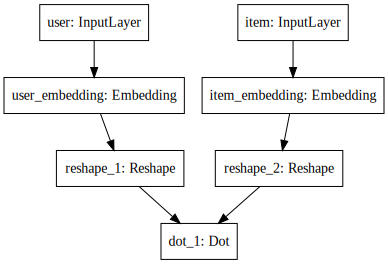

In [65]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

To save the different models, I used keras ModelCheckpoint callback.

In [114]:
import time
from keras.callbacks import ModelCheckpoint
mainpath = '/data.nfs/pgutierrez/beer_reco'
save_path = mainpath + "/models"
mytime = time.strftime("%Y_%m_%d_%H_%M")
modname = 'matrix_facto_50_' + mytime 
thename = save_path + '/' + modname + '.h5'
mcheck = ModelCheckpoint(thename  , monitor='val_loss', save_best_only=True)

Now we can train the model.

In [ ]:
history = model.fit([ratings_train["user_id"], ratings_train["beer_id"]]
                    , ratings_train["score"]
                    , batch_size=64, epochs=10
                    , validation_split=0.1
                    , callbacks=[mcheck]
                    , shuffle=True)

import pickle
with open(mainpath + '/histories/' + modname + '.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


And look at the corresponding history

0         1         2         3         4         5   \
loss      3.282131  0.697876  0.467870  0.368187  0.309391  0.270531   
val_loss  1.010002  0.689172  0.583937  0.532542  0.505037  0.490072   

                6         7         8         9         10        11  \
loss      0.242532  0.220680  0.203654  0.190286  0.180526  0.173244   
val_loss  0.479538  0.472309  0.467850  0.466473  0.465188  0.466323   

                12        13        14        15        16        17  \
loss      0.168040  0.163784  0.160461  0.157619  0.155266  0.152941   
val_loss  0.466727  0.469903  0.471110  0.472099  0.473838  0.477046   

                18        19  
loss      0.151294  0.149745  
val_loss  0.477645  0.478870

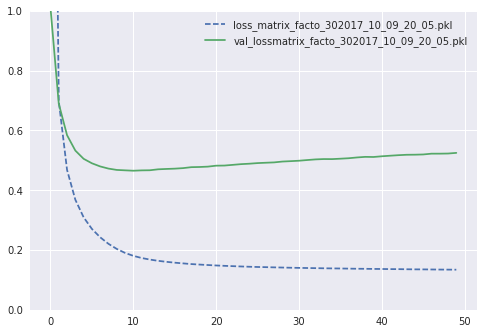

In [26]:
histories = ['matrix_facto_302017_10_09_20_05.pkl']

import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plot(thepickle["val_loss"],label='val_loss' + val)
plt.legend()
plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

The training loss stabilizes around 0.15. After 10 epochs, the model start overfitting, giving us a best mse validation loss around 0.465.
A quick grid search on the embedding sizes gives us: 

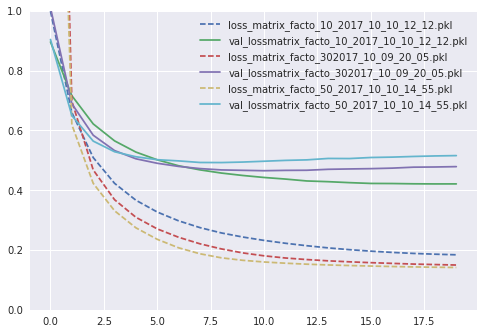

In [24]:

histories = ['matrix_facto_10_2017_10_10_12_12.pkl','matrix_facto_302017_10_09_20_05.pkl','matrix_facto_50_2017_10_10_14_55.pkl']

import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for i,val in enumerate(histories):
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plot(thepickle["loss"][:20],label ='loss_' + val,linestyle="--")
        plot(thepickle["val_loss"][:20],label='val_loss' + val)
plt.legend()
a= plt.ylim(0, 1)


Which shows that choosing large values of embedding sizes actually leads to overfitting. Hence, for most of the experimentations we will keep this embedding size of 10 (giving us around 0.42 validation mse)

You may have noticed that we are using the internal keras validation instead of our test to evaluate our models. This is because we are going to grid search many parameters and architecture. Since we are exploring and going to follow the most promising leads, we are prone to overfit manually. The test set will be kept to verify the quality of recommendations at the end of this part. 

Now, let's go deeper. 

## Going deeper 

The architecture above is trying to predict a rating by performing a dot product. We can relax the dot assumption and instead use a concatenate layer followed by a dense layer. This means that instead of relying on a simple dot product, the netwrok can find itself the way it wants to combine the information.

With a two layer deep neural network, this gives us using keras:

In [68]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras import optimizers

In [69]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 10 # 5
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=beers.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])

x = Dense(128, activation='relu')(input_vecs)
# x = Dense(128, activation='relu')(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')  

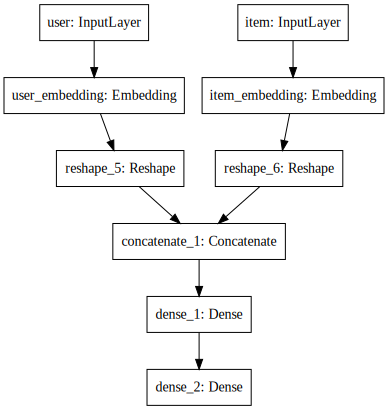

In [70]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Running the model we obtain the following curve:

0         1         2         3         4         5   \
loss      0.269783  0.210583  0.204253  0.200291  0.197833  0.196008   
val_loss  0.211035  0.207652  0.205352  0.205727  0.209358  0.206124   

                6        7         8         9         10        11        12  \
loss      0.194539  0.19332  0.192284  0.191359  0.190491  0.189853  0.189228   
val_loss  0.205076  0.20627  0.205641  0.211541  0.220987  0.210864  0.211884   

                13        14        15        16        17        18        19  
loss      0.188460  0.188130  0.187473  0.186994  0.186573  0.186222  0.185809  
val_loss  0.213006  0.206713  0.210470  0.214230  0.214933  0.213901  0.210559

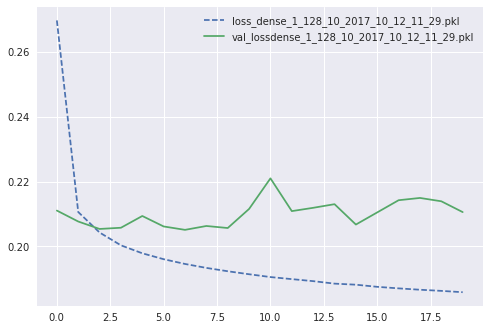

In [27]:
histories = ['dense_1_128_10_2017_10_12_11_29.pkl']

import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plot(thepickle["loss"][:20],label ='loss_' + val,linestyle='--')
        plot(thepickle["val_loss"][:20],label='val_loss' + val)
plt.legend()
#plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).transpose()

And when comparing with the previous model, this gives us:

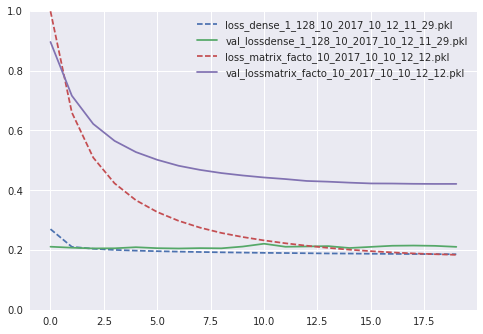

In [29]:
histories = ['dense_1_128_10_2017_10_12_11_29.pkl','matrix_facto_10_2017_10_10_12_12.pkl']

import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plot(thepickle["loss"][:20],label ='loss_' + val,linestyle='--')
        plot(thepickle["val_loss"][:20],label='val_loss' + val)
plt.legend()
lim = plt.ylim(0, 1)


Obviously, the performance way got better! From 0.42 to 0.205 validation loss. Wa can also notice the following points:
- we converge really fast to the best model. After one or two epoch, the model starts overfitting or at least the validation loss does not seem to stabily go down anymore.
- when comparing to the previous model, we almost manage to match the training error with our validation error! This may mean that we are close to reaching the best possible validation error.

We can also grid search around this architecture. What happens if we add another layer on top of the first one ? What happens if we decrease the embedding size ? (modifications commented in the code above)

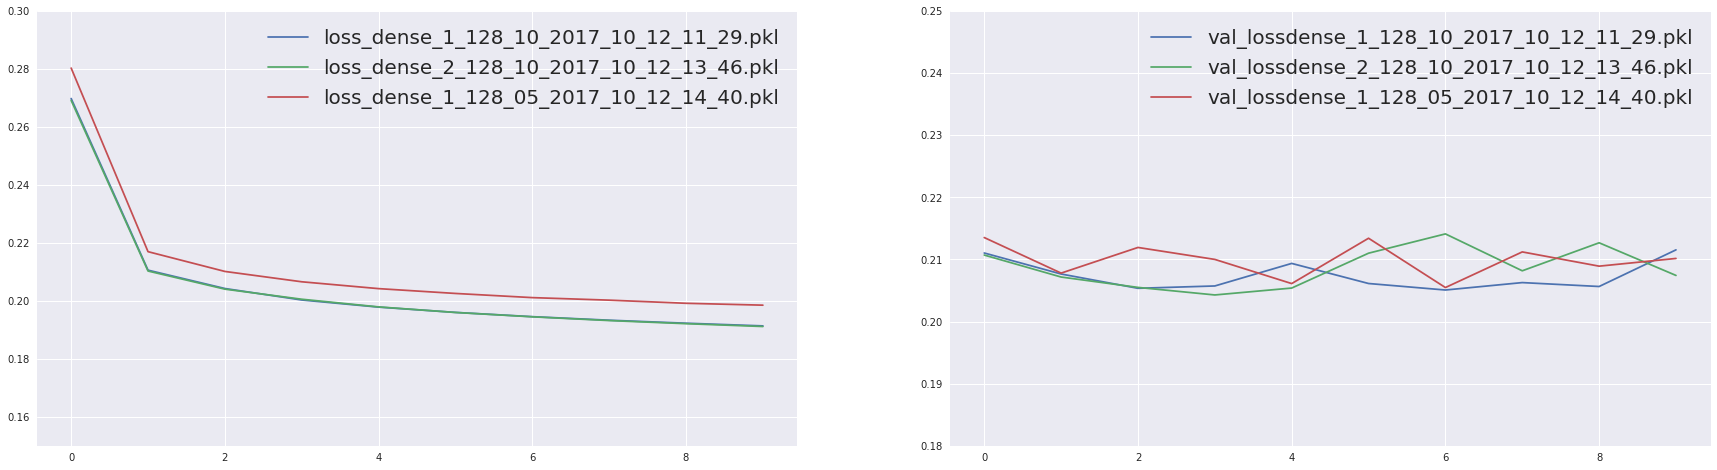

In [169]:
histories = ['dense_1_128_10_2017_10_12_11_29.pkl'
             ,'dense_2_128_10_2017_10_12_13_46.pkl','dense_1_128_05_2017_10_12_14_40.pkl']

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20)
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20)
plt.subplot(121)
a = plt.ylim(0.15, 0.3)
plt.subplot(122)
a = plt.ylim(0.18, 0.25)

We can see that unexpetedly, adding a layer does not help much (val_lossdense_2). In the opposite direction, simplifying the model by reducing embedding size does not help either. 

Now before going further in the architecture grid search, let's get a grasp of what the model does by looking at our generated embeddings.

## Visualizing embeddings

** Having a look at similar beers **

The first thing we can do is to vizualize closer beers to a given list to see if it matches our expectations. Let's follow this list: 

In [90]:
data=np.array([
    ['Coors light',837,"Oh my god why."],
    ['Heineken',246,"Euro basic blond beer. To be drank in the sun, or if in the north/east, add Picon."],
    ['Leffe Blonde', 2137,"My personally most hated beer. Entry belgium beer way too much wildspread in France."],
    ["Lindemans Kriek",600,"Beer with fruits. Sugary."],
    ["Chimay Bleue",2512,"Probably the most well known Trappist beer. Entry point for most beer lovers in France."],
    ["Lagunitas IPA",916,"Well known USA IPA. Difficult to find in Europe"],
    ["Firestone double Jack",50697,"Double IPA from Firestone. Very bitter. Awesome beer. Probably for conoisseurs."],
    ["Tsarina Esra",40959,"Imperial stout. You can't go more way more beer geek than this."]])
mybeers = pd.DataFrame(data=data,columns = ['name','id','Description'])
mybeers['id'] = mybeers['id'].map(inverse_beer_map).astype(int)

pd.set_option('display.max_colwidth', -1)
mybeers

name     id  \
0  Coors light            475     
1  Heineken               16887   
2  Leffe Blonde           73044   
3  Lindemans Kriek        39850   
4  Chimay Bleue           15782   
5  Lagunitas IPA          50447   
6  Firestone double Jack  64614   
7  Tsarina Esra           50      

                                                                               Description  
0  Oh my god why.                                                                           
1  Euro basic blond beer. To be drank in the sun, or if in the north/east, add Picon.       
2  My personally most hated beer. Entry belgium beer way too much wildspread in France.     
3  Beer with fruits. Sugary.                                                                
4  Probably the most well known Trappist beer. Entry point for most beer lovers in France.  
5  Well known USA IPA. Difficult to find in Europe                                          
6  Double IPA from Firestone. Very bitter. Awesome beer. Probably for conoisseurs.          
7  Imperial stout. You can't go more way more beer geek than this.

And let's define a function to get the closest beers in the embedding from them. 

In [91]:
"""NO SHOW THAT
I SHOULD HAVE THIS MORE PROPER SOMEWHERE"""
# getting the mapping
beer_infos = pd.read_csv('/data/pgutierrez/beer/all_beer_info.csv.gz', sep=',')
beer_infos['beer_id'] = beer_infos['beer_url'].map(lambda x : x.split("/")[-2])
beer_infos["map_id"]=beer_infos["beer_id"].map(inverse_beer_map)
namesdic = {row[1]['map_id']:row[1]['name']  for row in beer_infos.iterrows()}

In [92]:
EPSILON = 1e-07

def cosine(x, y):
    dot_pdt = np.dot(x, y.T)
    norms = np.linalg.norm(x) * np.linalg.norm(y)
    return dot_pdt / (norms + EPSILON)


def cosine_similarities(x,embeddings):
    dot_pdt = np.dot(embeddings, x)
    norms = np.linalg.norm(x) * np.linalg.norm(embeddings,axis = 1)
    return dot_pdt / (norms + EPSILON)

# Computes euclidean distances between x and all item embeddings
def euclidean_distances(x,embeddings):  
    return np.linalg.norm(embeddings - x,axis=1)

# Computes top_n most similar items to an idx
def most_similar(idx, embeddings,top_n=10,euclidian= False):
    if euclidian:
        # eucliedian distance between idx and the rest
        distance = euclidean_distances(embeddings[idx],embeddings)
        order = (distance).argsort()
        order= [x for x in order if x <> idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))
    else: 
        # cosine similarity between idx and the rest
        distance = cosine_similarities(embeddings[idx],embeddings)
        order = (-distance).argsort()
        order= [x for x in order if x <> idx]
        order= order[:top_n]
        return list(zip([namesdic[x] for x in order], distance[order]))

    

Let's get closets beer for the matrix factorisation model obtained with the dot layer:

In [93]:
# the embeddings are the first layer weights
from keras.models import load_model
load_path = "/data.nfs/pgutierrez/beer_reco/models/"
model = load_model(load_path+'matrix_facto_10_2017_10_10_12_12.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print "weights shapes",[w.shape for w in weights]

weights shapes [(91645, 10), (78518, 10)]


In [94]:
from IPython.core import display as ICD
dataframes = []
for i,row in enumerate(mybeers.iterrows()):
    row = row[1]
    similars = pd.DataFrame(most_similar(row["id"],item_embeddings,top_n=10,euclidian= False))
    similars.columns = [row["name"]+' Closest',row["name"]+' Score' ]
    dataframes.append(similars)
    if i % 2 ==1 :
        final = pd.concat(dataframes,axis=1)
        ICD.display(final)
        dataframes=[]

Coors light Closest  Coors light Score         Heineken Closest  \
0  Bud Light            0.978795           Superior                  
1  Miller Lite          0.975721           Beck's                    
2  Michelob Ultra       0.970546           Chang Beer (Export)       
3  Budweiser Select     0.969926           Brown Fox Session Ale     
4  Bud Light Platinum   0.963584           Amstel Lager              
5  Budweiser Select 55  0.957238           Maibock                   
6  Michelob Light       0.953016           Birra Peroni              
7  Tecate Light         0.951688           Rolling Rock Extra Pale   
8  Kirin Light Beer     0.951604           Sol                       
9  Busch Light          0.946506           Asahi Super Dry           

   Heineken Score  
0  0.959585        
1  0.958840        
2  0.953909        
3  0.952309        
4  0.949430        
5  0.944654        
6  0.942317        
7  0.942249        
8  0.941787        
9  0.939921

Leffe Blonde Closest  Leffe Blonde Score  \
0  Korova Milk Porter               0.988748             
1  Hoppopotamus I.P.A.              0.985438             
2  Big Eddy Russian Imperial Stout  0.983687             
3  Nine Voices                      0.981028             
4  Immort Ale                       0.980868             
5  Raison D'Être                    0.977779             
6  Samuel Adams Chocolate Bock      0.975969             
7  Trikini                          0.972123             
8  Innis And Gunn Oak Aged Beer     0.971600             
9  CBC Classic Lager                0.967656             

                               Lindemans Kriek Closest  Lindemans Kriek Score  
0  River Horse Belgian Freeze Belgian Style Winter Ale  0.988397               
1  Stoudt's Triple (Belgian Abbey-Style Ale)            0.987153               
2  Fullsuit Belgian-Style Brown Ale                     0.986378               
3  Big Eddy Wee Heavy Scotch Ale                        0.984225               
4  Winter Warmer                                        0.983860               
5  Crush Beer                                           0.980558               
6  Petrus Blond                                         0.978730               
7  Old Double Bagger (ODB)                              0.978404               
8  Irish Setter Red                                     0.977576               
9  Leffe De Noël                                        0.977054

Chimay Bleue Closest  Chimay Bleue Score  \
0  Chimay Tripel (White)                   0.993961             
1  Ayinger Celebrator Doppelbock           0.992905             
2  Trappistes Rochefort 6                  0.991883             
3  Schneider Weisse Tap 6 Unser Aventinus  0.991332             
4  Chimay Première (Red)                   0.991170             
5  La Chouffe                              0.990845             
6  Rare Vos (Amber Ale)                    0.990526             
7  Pranqster                               0.990228             
8  St. Bernardus Pater 6                   0.989876             
9  Westmalle Trappist Dubbel               0.989362             

          Lagunitas IPA Closest  Lagunitas IPA Score  
0  Devil Dog Imperial IPA        0.983049             
1  Ranch Double IPA              0.982516             
2  A Little Sumpin' Sumpin' Ale  0.981847             
3  DirtWolf                      0.979956             
4  Bell's Oberon Ale             0.978370             
5  Great Lakes Christmas Ale     0.978363             
6  Maierfest Lager               0.977886             
7  New Holland Imperial Hatter   0.977791             
8  Sculpin IPA                   0.977255             
9  Hopslam Ale                   0.976874

Firestone double Jack Closest  \
0  Myrcenary Double IPA                                      
1  Narwhal Imperial Stout                                    
2  Apex                                                      
3  Espresso Imperial Russian Stout                           
4  Modus Hoperandi                                           
5  D.O.R.I.S. The Destroyer Double Imperial Stout            
6  Green Flash Imperial India Pale Ale                       
7  Café Racer 15                                             
8  The Devil Made Me Do It! Coffee Imperial Oatmeal Porter   
9  NightTime                                                 

   Firestone double Jack Score                Tsarina Esra Closest  \
0  0.995100                     Santa's Little Helper 2012           
1  0.994915                     Klokke Roeland                       
2  0.994892                     Flower Child IPA                     
3  0.994810                     Panil Barriquée (Sour Version)       
4  0.994788                     De Viento                            
5  0.994764                     Fusion 18                            
6  0.994161                     Le Capitaine                         
7  0.993976                     Great Lakes RoboHop                  
8  0.993843                     I See A Darkness                     
9  0.993701                     Brown Barleywine TBC Collaboration   

   Tsarina Esra Score  
0  0.992227            
1  0.991870            
2  0.991121            
3  0.990704            
4  0.990359            
5  0.989791            
6  0.989658            
7  0.989278            
8  0.989091            
9  0.989078

Let's have a look at the results:
- For Coors light, we do pick up similar light beers, as well as the budweiser assortment.
- For Heineken, the results seem to match our expectations. We find mostly blond lagers from all over the world: Birra Peroni from Italy, Asahi from Japan, Beck's from Germany, Sol and Superior from Mexico or Amstel from Netherland (and actually Amstel belongs to Heineken).  It's interesting to see that most of these beers are not from the USA whereas equivalent exists. This is because our users are mostly from the USA so Heineken is thought as a foreign beer, leading to a high similarity to other foreign beers. 

Indeed if we have a look at the country distribution: 

In [95]:
users_infos = pd.read_csv('/data/pgutierrez/beer/users.csv.gz', sep=',')
users_infos = users_infos.fillna('no_data')
country_count = users_infos.location.value_counts().reset_index()
country_count.columns = ["location","nb_users"]
country_count['perc_users'] = country_count['nb_users'].astype(float)/country_count['nb_users'].sum()
country_count['cum_perc_users'] = country_count['perc_users'].cumsum()
country_count.head(15)

location  nb_users  perc_users  cum_perc_users
0   no_data         16269     0.186059    0.186059      
1   California      7016      0.080238    0.266297      
2   Pennsylvania    5488      0.062763    0.329060      
3   New York        4247      0.048570    0.377630      
4   Illinois        4220      0.048262    0.425892      
5   Massachusetts   3854      0.044076    0.469968      
6   Texas           3342      0.038220    0.508188      
7   Ohio            2894      0.033097    0.541285      
8   Florida         2652      0.030329    0.571615      
9   Michigan        2394      0.027379    0.598994      
10  New Jersey      2262      0.025869    0.624863      
11  Virginia        2125      0.024302    0.649165      
12  North Carolina  2031      0.023227    0.672392      
13  Minnesota       1792      0.020494    0.692887      
14  Indiana         1575      0.018012    0.710899

So we have around 20% of unknown locations and more than 50% of American users.

In fact if we look at the non US entries in the list we get:
- The state of Ontario(Canada) as the first entry with 718 users
- United Kingdom and Australia as the two first countries with respectively 348 and 306 users
- France arrives at the 69th position with 62 users.

Back to our results on closest beers: 
- for Leffe, the results are less interpretable. It seems to be drank along other style of beers like IPA or Stout while it's a classical Belgium beer. If all users were French we would probably find Grimbergen or Affligem instead.
- For Lindermans, the results are not that good either. We find that it's associated with some winter or belgium beers (Petrus for example) but we totally miss the fruit idea.
- Chimay is different. The matches make a lot of sense. First because we find the two other Chimay (blue and white). Then because we find other Trappist beers (Rochefort, Westmale) or Belgium beers (Chouffe, St Bernardus). Form my perspective, recommending these beers to a Chimay drinker would indeed be smart... unless it's way to obvious. 
- I let the American beer fan comment on the Lagunitas. I know the Sculpin which seems a good match but my American IPA culture is not strong enough. We do see mostly American IPA and Ales though which seems good. 
- Finally, for the Firestone double IPA and the Tsarina, we find mostly beergeek beers: double ipa, imperial stouts and unusual beers. 

** Conclusion: ** overall we do have a good match and closest beer seem to make sense. It is possible to check the euclidian distance instead of the cosine similarity but the results are very similar. The unexpected behaviour (like the one of Leffe) seems mostly due to the bias of the dataset since most users are American. An other bias that we should be aware of is the fact that most users are likely to be beergeeks and thus the Coors Light type of beers will always be rated low.

What happens if we now check the embeddings retrieved by a deeper model ? 

In [96]:
# the embeddings are the first layer weights
from keras.models import load_model
load_path = "/data.nfs/pgutierrez/beer_reco/models/"
model = load_model(load_path+'dense_1_128_10_2017_10_12_11_29.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
print "weights shapes",[w.shape for w in weights]

weights shapes [(91645, 10), (78518, 10), (20, 128), (128,), (128, 1), (1,)]


In [97]:
mybeers

name     id  \
0  Coors light            475     
1  Heineken               16887   
2  Leffe Blonde           73044   
3  Lindemans Kriek        39850   
4  Chimay Bleue           15782   
5  Lagunitas IPA          50447   
6  Firestone double Jack  64614   
7  Tsarina Esra           50      

                                                                               Description  
0  Oh my god why.                                                                           
1  Euro basic blond beer. To be drank in the sun, or if in the north/east, add Picon.       
2  My personally most hated beer. Entry belgium beer way too much wildspread in France.     
3  Beer with fruits. Sugary.                                                                
4  Probably the most well known Trappist beer. Entry point for most beer lovers in France.  
5  Well known USA IPA. Difficult to find in Europe                                          
6  Double IPA from Firestone. Very bitter. Awesome beer. Probably for conoisseurs.          
7  Imperial stout. You can't go more way more beer geek than this.

In [98]:
mybeers2 = mybeers[mybeers['id'].isin([475,16887,15782,50447])]
dataframes = []
for i,row in enumerate(mybeers2.iterrows()):
    row = row[1]
    similars = pd.DataFrame(most_similar(row["id"],item_embeddings,top_n=10,euclidian= False))
    similars.columns = [row["name"]+' Closest',row["name"]+' Score' ]
    dataframes.append(similars)
    if i % 2 ==1 :
        final = pd.concat(dataframes,axis=1)
        ICD.display(final)
        dataframes=[]

Coors light Closest  Coors light Score          Heineken Closest  \
0  Milwaukee's Best Ice      0.996696           Bavaria Beer / Pilsener    
1  Budweiser Select          0.995665           Mr. Punch                  
2  Natural Light             0.995015           Budweiser                  
3  Miller 64                 0.994731           Foster's Export            
4  Michelob Ultra            0.994584           Boddingtons Pub Ale        
5  Miller Chill              0.994191           Žaibo                      
6  Bud Light                 0.994100           Key West Sunset Ale        
7  Icehouse                  0.994055           San Miguel Especial        
8  Milwaukee's Best Premium  0.991707           Windy Gap Wheat            
9  Busch Beer                0.991293           Dabob Bay India Pale Ale   

   Heineken Score  
0  0.991667        
1  0.991157        
2  0.991082        
3  0.990888        
4  0.990460        
5  0.990229        
6  0.989983        
7  0.989482        
8  0.988779        
9  0.986460

Chimay Bleue Closest  Chimay Bleue Score  \
0  Trois Pistoles              0.998028             
1  La Fin Du Monde             0.990438             
2  Burton Baton                0.989614             
3  Allagash Odyssey            0.988587             
4  Green Flash West Coast IPA  0.987935             
5  Green Flash Palate Wrecker  0.987310             
6  Scottish Ale                0.987281             
7  Dark Island                 0.986381             
8  90 Minute IPA               0.985973             
9  Westmalle Trappist Tripel   0.985170             

                            Lagunitas IPA Closest  Lagunitas IPA Score  
0  Tang And Biscuits                               0.995972             
1  Sucre - Tawny Port Barrel Aged                  0.995160             
2  Flying Monkeys Ryezin’ Up The Rye Of The Tiger  0.994247             
3  Iris Pale Ale                                   0.994117             
4  Zywiec Porter                                   0.993770             
5  Darwin                                          0.992140             
6  Draft Bear                                      0.991880             
7  Irish Oatmeal Stout                             0.991712             
8  Double Red IPA                                  0.991538             
9  The Scarlet Letter                              0.991528

When restricting to the beers that were working the best previously, we see that the ratings make less sense. While it is still good for Coors Light and correct for Heineken, the results worsen (at the interpretation level). For chimay, we lost the Chimay beers, one trappist and got IPAs instead. For Lagunitas, we recommend less IPAs.

It is unclear why the embeddings show less inutitive results. Let's see what it gives us using the tsne dimension reduction technique. 

** tsne of the embeddings **

Let's randomly select 10000 beers and apply a tsne transformation on their embeddings.

In [99]:
# the embeddings are the first layer weights
from keras.models import load_model
load_path = "/data.nfs/pgutierrez/beer_reco/models/"
model = load_model(load_path+'matrix_facto_10_2017_10_10_12_12.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]
#print "weights shapes",[w.shape for w in weights]

In [100]:
import random
random.seed(0)
smallbeers = [inverse_beer_map[x] for x in random.sample(beers,10000)]
smallembedding = item_embeddings[smallbeers]

smallusers = [inverse_user_map[x] for x in random.sample(users,10000)]
smallembedding2 = user_embeddings[smallusers]

mostratedbeers = all_info[['beer_id','nb_lines']].sort('nb_lines',ascending=False).head(10000)
mostratedbeers = [int(x) for x in mostratedbeers["beer_id"].values]
mostratedembeddings = item_embeddings[mostratedbeers]

leastratedbeers = all_info[['beer_id','nb_lines']].sort('nb_lines').head(10000)
leastratedbeers = [int(x) for x in leastratedbeers["beer_id"].values]
leastratedembeddings = item_embeddings[mostratedbeers]

In [84]:
from sklearn.manifold import TSNE
%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = smallbeers
a['old_id'] = [beer_map[x] for x in smallbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot.csv")


from sklearn.manifold import TSNE
%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding2)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["user_id"] = smallusers
a['old_id'] = [user_map[x] for x in smallusers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot_user.csv")

We get

(-10, 10)

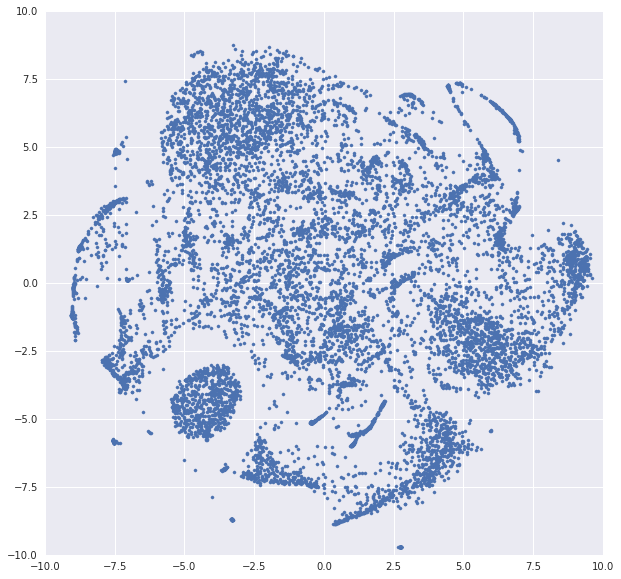

In [129]:
a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot.csv")
b = pd.merge(a,all_info, how='left',left_on ='old_id', right_on = 'old_id') 

plt.figure(figsize=(10,10))
sc = plt.scatter(b['x'], b['y'],s=10)
plt.xlim(-10, 10)
plt.ylim(-10, 10)

At first, you may think that we have here very structured information with well separated clusters. It turns out, it is not possible to correlate any of these shapes with a style or origin of the beer (trust me I tried). I manually checked some areas and was not able to make sense out of it. 

In fact, the structure that we have is mostly driven by two axes: the average rating of the beer and the number of times it has been rated. Below, the first graph shows the same data colored by average rating. We see on the left side a cluster of poorely rated beers (mostly American laggers) and some red of yellow clusters (top, center, bottom). The second charts shows the tsne representation colored by the log of the number of times the beer was rated. We can see that at the center of the map, lies the most popular beers while the round cluster on the bottom consists of beer that were rated only once (and thus cannot be linked to any other beer). 

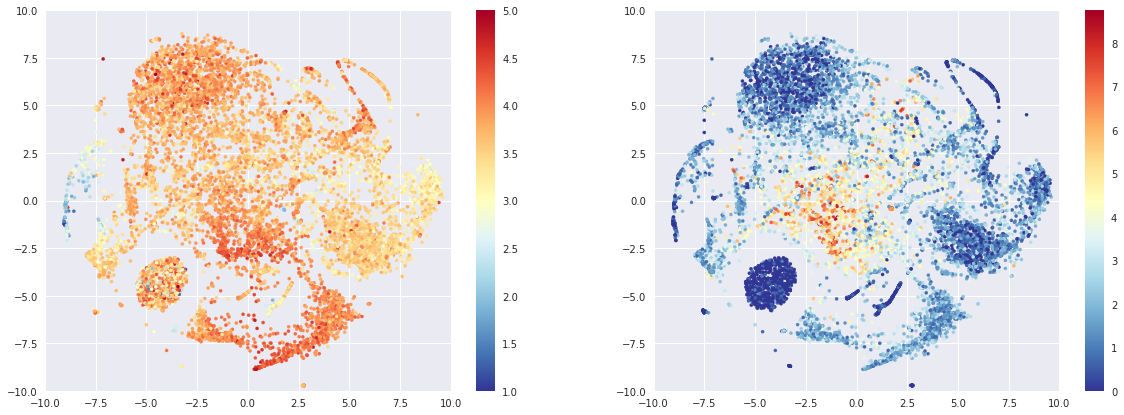

In [86]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.log(b['nb_lines']),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()

The exact same effect appears if we look at the user embeddings. 

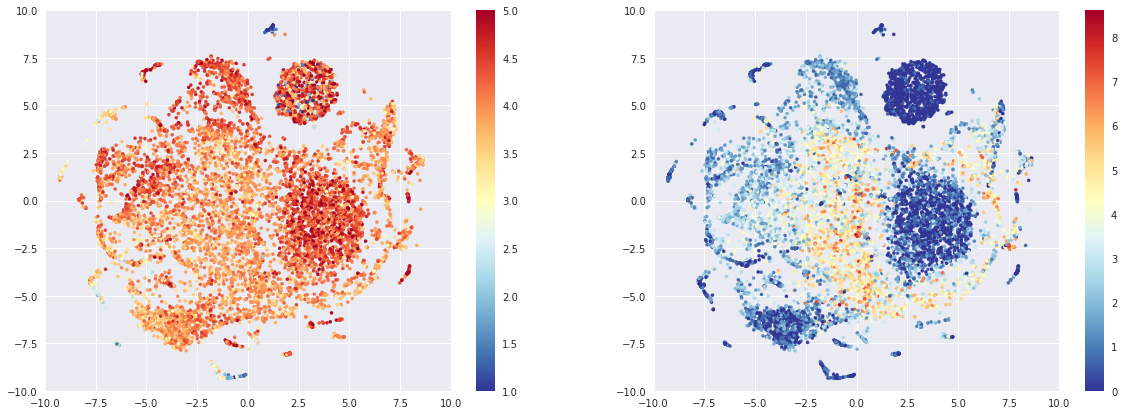

In [125]:
a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot_user.csv")
users_infos = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/all_info_users.csv")
b = pd.merge(a,users_infos, how='left',left_on ='old_id', right_on = 'user_id') 

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.log(b['nb_lines']),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()

Interestingly, we get the 1 rating cluster again. It would be interesting to dive into the maths of this. This may be due to the fact that beers rated only once and being the only rating of the user cannot be linked to any othe beer and are in a way replacable by each others, so close in our space. 

If instead of choosing 10000 beers, we pick the 10000 most popular beer in terms of records, the structure actually disappear and we get a big blob with an almost linear rating gradation.

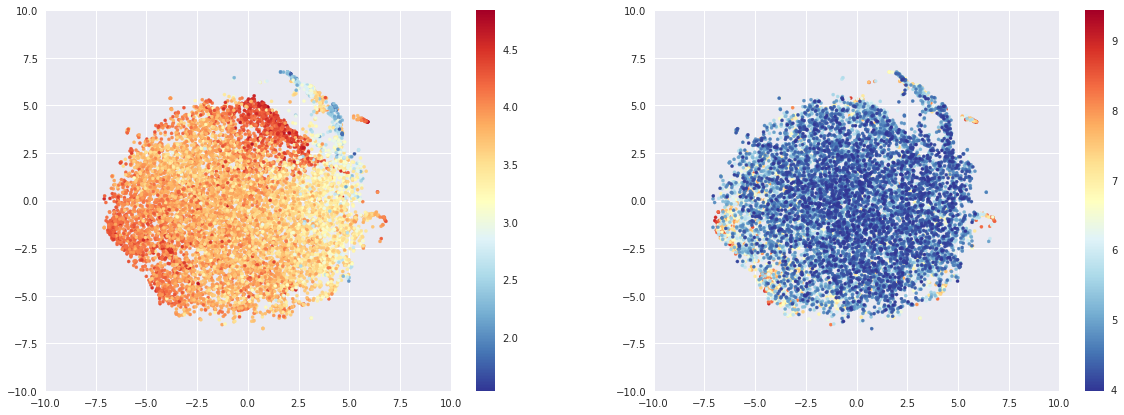

In [103]:
%time item_tsne = TSNE(perplexity=30).fit_transform(mostratedembeddings)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = mostratedbeers
a['old_id'] = [beer_map[x] for x in mostratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot_mostrated.csv")

a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_dot_mostrated.csv")
b = pd.merge(a,all_info, how='left',left_on ='old_id', right_on = 'old_id') 
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.log(b['nb_lines']),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()

Now we can compare this to the neural network model embeddings.

In [104]:
# the embeddings are the first layer weights
load_path = "/data.nfs/pgutierrez/beer_reco/models/"
model = load_model(load_path+'matrix_facto_10_2017_10_10_12_12.h5')
weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]

smallembedding = item_embeddings[smallbeers]
mostratedembeddings = item_embeddings[mostratedbeers]

%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = smallbeers
a['old_id'] = [beer_map[x] for x in smallbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_deep.csv")

%time item_tsne = TSNE(perplexity=30).fit_transform(mostratedembeddings)
a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = mostratedbeers
a['old_id'] = [beer_map[x] for x in mostratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_deep_mostrated.csv")


CPU times: user 2min 48s, sys: 45.7 s, total: 3min 34s
Wall time: 3min 32s
CPU times: user 2min 21s, sys: 39.4 s, total: 3min
Wall time: 2min 58s


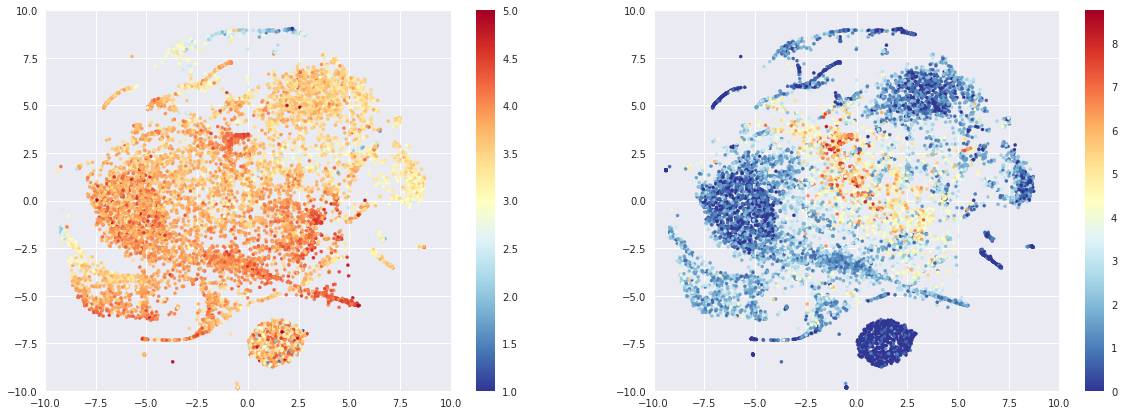

In [106]:
a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_deep.csv")
b = pd.merge(a,all_info, how='left',left_on ='old_id', right_on = 'old_id') 

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.log(b['nb_lines']),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()


We get the same structure derived mostly from average rating and number of ratings. Finally, if we look at the tsne for top 10000 beers we get:

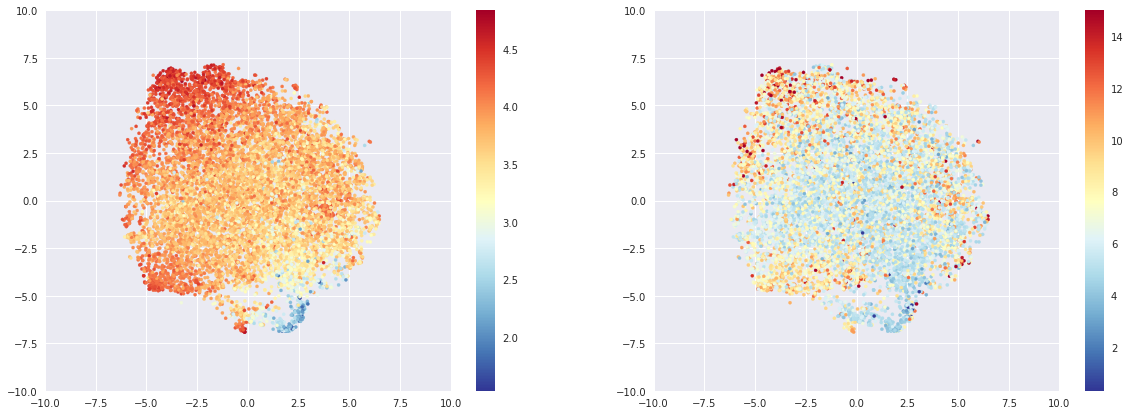

In [117]:
a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_deep_mostrated.csv")
b = pd.merge(a,all_info, how='left',left_on ='old_id', right_on = 'old_id') 

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.minimum(b['abv'],15),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()


Where the second graph is actually colored by the abv, maxed at 15 (to avoid abv outliers). You can see that abv is strongly correlated to the ratings, which again shows our user bias toward craft strong beers.

As a conclusion, we see that the t-sne of the embedding is not easily interpretable and that it is mostly derived from average and number of ratings. For the neural network model, even the closest beer results become not interpretable. Note that we would not care too much if the final recommendations make sense in AB tests.

## Grid Searching the architecture

The architecture we defined in previous parts are simple. Indeed, it's either a dot product between embeddings or a concat layer before two dense layers. In the following we will try to gain performance by modifying the architecture of the network. 

Here are a few idea I we are going to test:
- Change the dot/concat merge layer by a multiply. The idea here would be to relax the dot product so that the network can choose it's own weighted dot product, but at the same time keep the multipliction structure.
- The second idea is to try to improve the dot network by making it deeper. The problem is we cannot add a dense layer after the dot prodict since we are left with only one scalar value. An idea could be to add these dense layers before the dot product and have two "towers in" the architecture.
- We can use this idea with other architectures and create a network with two dense layers on embeddings, a concat layer, and then other dense layers. 

Let's make this a little more concrete. With keras the first idea gives us:

In [33]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras import optimizers

In [34]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 10
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=beers.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

# Add dense towers or not.
# user_vecs = Dense(64, activation='relu')(user_vecs) 
# item_vecs = Dense(64, activation='relu')(item_vecs)

input_vecs = Multiply()([user_vecs, item_vecs]) # can be changed by concat or dot. (if dot, no dense after)/
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(128, activation='relu')(input_vecs)
#x = Dropout(0.2)(x) # Add droupout or not 
#x = Dense(64, activation='relu')(x) # Add dense again or not 
#x = Dropout(0.2)(x) # Add droupout or not 
#x = Dense(32, activation='relu')(x) # Add dense again or not 

y = Dense(1)(x)

model = Model(inputs=[user_id_input, item_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')  

** Experiment 1: ** Using Multiply merge layer instead of Concat.  

The following charts show the loss for different mutiply architectures. I varied the depth of the network after the merge layer (one dense 128 or two dense 64,64 or three denses 128,64,32) as well as the presence of dropout. None of these models seem to beat our previous benchmark. This probably means that we have enough data for the network to be able to create it's own merging function. 

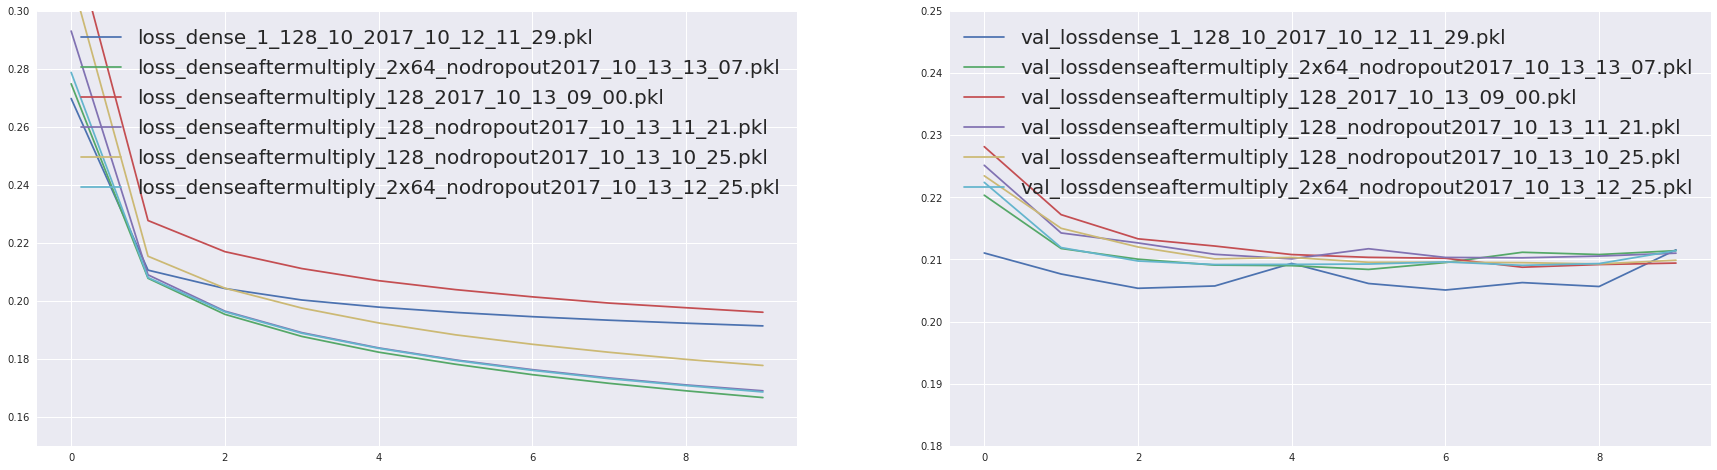

In [109]:
histories = ['dense_1_128_10_2017_10_12_11_29.pkl'
             ,'denseaftermultiply_2x64_nodropout2017_10_13_13_07.pkl'
             ,'denseaftermultiply_128_2017_10_13_09_00.pkl'
             ,'denseaftermultiply_128_nodropout2017_10_13_11_21.pkl'
             ,'denseaftermultiply_128_nodropout2017_10_13_10_25.pkl' # this one is actually 128,64,32
             ,'denseaftermultiply_2x64_nodropout2017_10_13_12_25.pkl']

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20)
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20)
plt.subplot(121)
a = plt.ylim(0.15, 0.3)
plt.subplot(122)
a = plt.ylim(0.18, 0.25)


** Experiment 2: ** Using dense before dot product.  

Adding these dense layers before the dot product works great. As expected, it improoves drastically the performance of the matrix factorization (the corresponding evaluation loss is out of the picture here because it's around 0.4). It's also interesting to see that the evaluation loss is very similar to our dense benchmark, and goes even lower. This raises the question: should ve use this dense before merge for the Concat layer ? 

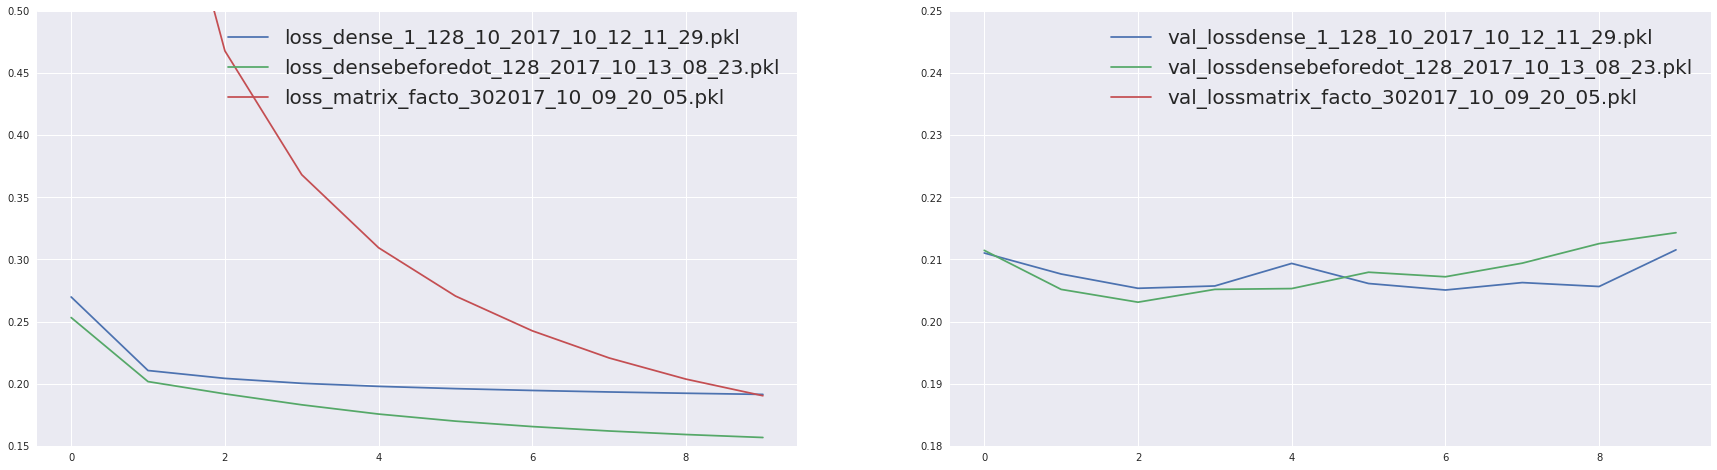

In [113]:
histories = ['dense_1_128_10_2017_10_12_11_29.pkl'
             ,'densebeforedot_128_2017_10_13_08_23.pkl'
             ,'matrix_facto_302017_10_09_20_05.pkl'
             ]

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20)
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20)
plt.subplot(121)
a = plt.ylim(0.15, 0.5)
plt.subplot(122)
a = plt.ylim(0.18, 0.25)


** Experiment 3: ** Using towers before the merge layer.

We use dense 64 layers before the merge layer. This model gives us the best performance so far with a evaluation loss of 0.199690, our first model with loss under 0.2! Adding an extra dense layer after the Concat layer lead to a small drop of performance as well as complexifying the "towers" (for example with two 64 dense layers instead of 1).

As a result our best model architecture is: a dense layer on each embedding before concatenating them and adding two dense layers on top. Notice that the performance of all these models are still very close and we might start overfitting manually our internal test set. 

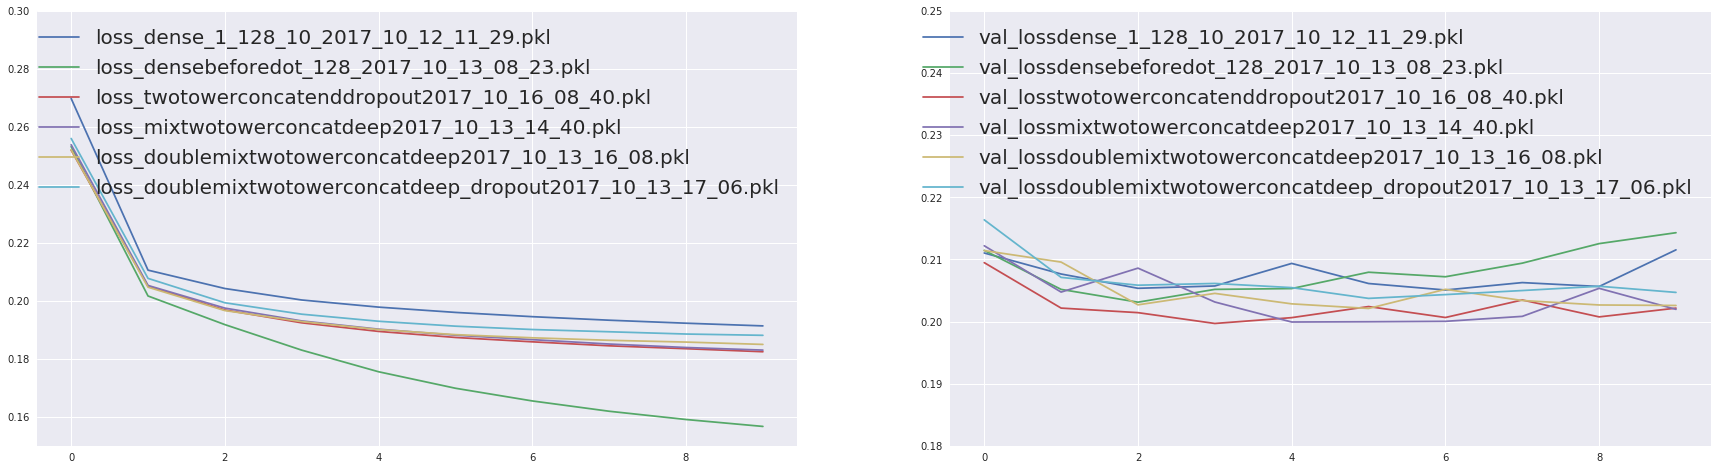

In [255]:
perf = {}
histories = [# our dense benchmark
             'dense_1_128_10_2017_10_12_11_29.pkl' 
             # towers before dot
             ,'densebeforedot_128_2017_10_13_08_23.pkl' 
             # two towers (dense 64), concat, dropout, dense 128, dropout, dense 1
             ,'twotowerconcatenddropout2017_10_16_08_40.pkl'
             # two towers (dense 64), concat, dense 128, dropout, dense 128, dropout, dense 1
             ,'mixtwotowerconcatdeep2017_10_13_14_40.pkl' 
             # two towers (dense 64, dense 64), concat, dropout, dense 128, dropout, dense 1
             ,'doublemixtwotowerconcatdeep2017_10_13_16_08.pkl'
             # two towers (dense 64,droupout, dense 64), concat, dropout, dense 128, dropout, dense 1
             ,'doublemixtwotowerconcatdeep_dropout2017_10_13_17_06.pkl'
            ]

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20)
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20)
        perf[val]=np.min(thepickle["val_loss"])
plt.subplot(121)
a = plt.ylim(0.15, 0.3)
plt.subplot(122)
a = plt.ylim(0.18, 0.25)

perf = pd.Series(perf)
perf.sort()

In [256]:
perf

twotowerconcatenddropout2017_10_16_08_40.pkl               0.199690
mixtwotowerconcatdeep2017_10_13_14_40.pkl                  0.199926
doublemixtwotowerconcatdeep2017_10_13_16_08.pkl            0.202105
densebeforedot_128_2017_10_13_08_23.pkl                    0.203117
doublemixtwotowerconcatdeep_dropout2017_10_13_17_06.pkl    0.203728
dense_1_128_10_2017_10_12_11_29.pkl                        0.205076
dtype: float64

Our best model architecture is thus:

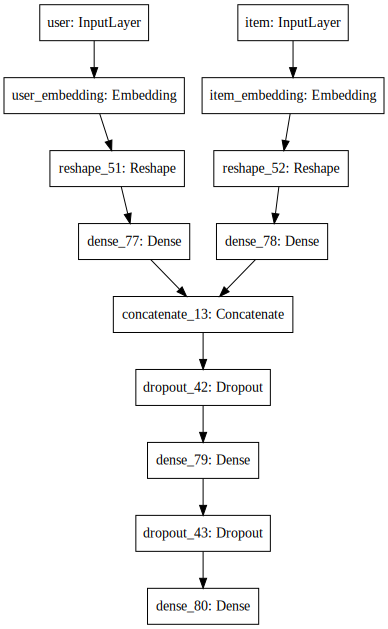

In [35]:
from keras.models import load_model
model = load_model('/data.nfs/pgutierrez/beer_reco/models/'+'twotowerconcatenddropout2017_10_16_08_40.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

** A note on the embeddings **

When looking at closest beers in the embeddings, we lost most of the interpretation that we had with the matrix factorization model. In fact for the two dense towers before dot model, there is still interpretation to be done for input embeddings layers, but not for the following one, as we can see the example of Chimay showed bellow. For concat models, all interpretation seem to be lost.

In [31]:
from keras.models import load_model
model = load_model('/data.nfs/pgutierrez/beer_reco/models/'+'densebeforedot_128_2017_10_13_08_23.h5')

weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[1]

similar1 = pd.DataFrame(most_similar(15782,item_embeddings,top_n=10,euclidian= False)
                        ,columns = ['Chimay emb bottom','Score'])

thebeers = np.array(range(len(beers)))
theusers = np.array(range(len(beers)))
layer_name = model.layers[6].name
m2 = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
item_embeddings2 = m2.predict([theusers,thebeers]) # dirty dirty

similar2 = pd.DataFrame(most_similar(15782,item_embeddings2,top_n=10,euclidian= False)
                        ,columns = ['Chimay emb tower','Score'])


sim = pd.concat([similar1,similar2],axis=1)
sim

Chimay emb bottom     Score            Chimay emb tower  \
0           St. Bernardus Abt 12  0.987436              Centennial Man   
1        Wolaver's Oatmeal Stout  0.986205  Stalk You Like A Hurricane   
2      Westmalle Trappist Tripel  0.986169                  Golden Ale   
3                    Brett Amber  0.984214                Polar Vortex   
4  Village Gardener Community...  0.983883    Irresistible Premium Ale   
5             Val-Dieu Grand Cru  0.983090                 Beer Esteam   
6         Trappistes Rochefort 8  0.982558        Terrier Scottish Ale   
7           Abaporu Imperial IPA  0.982465                    Mild End   
8        Trappistes Rochefort 10  0.981609         Swan Lake Brown Ale   
9               Tripel Karmeliet  0.981135      Four Play IPA Batch #3   

      Score  
0  0.997088  
1  0.996808  
2  0.996805  
3  0.996728  
4  0.996386  
5  0.996251  
6  0.996112  
7  0.996104  
8  0.996049  
9  0.995872

## Adding Metadata

One of the advantage of using neural networks for recommendation purposes is that we can create an architecture that mixes the collaborative and content based filtering approaches. Indeed, we will still try to predict the ratings and use this to calculate beers and users embeddings (collaborative part) but we will also add as inputs the metadata about beers and users (content based information). 

Theoritically, this should help us avoid the cold start problem. For example, having information about the brewery for a new beer might help, since other beers from this brewery have already been rated. The style or description of the beer will also help it finds it's audience (Light beer versus Imperial stout for example).

The following code shows how to integrate the country of the beer. 

### Adding the country

First we add all the metadata from the beers and the users in our training dataset.

In [35]:
# No need to read everything here.

# creating metadata mappings 
styles = all_info.sort("style")['style'].unique()
countries = all_info.sort("brewery_country")['brewery_country'].unique()
breweries = all_info.sort("brewery")['brewery'].unique()
styles_map = {i:val for i,val in enumerate(styles)}
inverse_styles_map = {val:i for i,val in enumerate(styles)}
country_map = {i:val for i,val in enumerate(countries)}
inverse_country_map = {val:i for i,val in enumerate(countries)}
brewery_map = {i:val for i,val in enumerate(breweries)}
inverse_brewery_map = {val:i for i,val in enumerate(breweries)}
print "We have %d countries" %countries.shape
print "We have %d styles" %styles.shape
print "We have %d breweries" %breweries.shape

all_info['beer_id'] = all_info['beer_url_x'].map(lambda x : x.split("/")[-2]).map(inverse_beer_map) # here put new id
all_info['country_id'] = all_info['brewery_country'].map(inverse_country_map)
all_info['style_id'] = all_info['style'].map(inverse_styles_map)
all_info['brewery_id'] = all_info['brewery'].map(inverse_brewery_map)

# creating dict from 
beer2countries = {}
for val in all_info[['beer_id','country_id']].dropna().drop_duplicates().iterrows():
    beer2countries[val[1]["beer_id"]] = val[1]["country_id"]

beer2styles = {}
for val in all_info[['beer_id','style_id']].dropna().drop_duplicates().iterrows():
    beer2styles[val[1]["beer_id"]] = val[1]["style_id"]
        
beer2breweries = {}
for val in all_info[['beer_id','brewery_id']].dropna().drop_duplicates().iterrows():
    beer2breweries[val[1]["beer_id"]] = val[1]["brewery_id"]        

beer2abv = {}
for val in all_info[['beer_id','abv']].dropna().drop_duplicates().iterrows():
    beer2abv[val[1]["beer_id"]] = val[1]["abv"]        

# populating the rating dataset with beer metadata info
ratings_train["country_id"] = ratings_train["beer_id"].map(lambda x : beer2countries[x])
ratings_train["style_id"] = ratings_train["beer_id"].map(lambda x : beer2styles[x])
ratings_train["brewery_id"] = ratings_train["beer_id"].map(lambda x : beer2breweries[x])
ratings_train["abv"] = ratings_train["beer_id"].map(lambda x : beer2abv[x])

# scale abv
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ratings_train["abv"] = scaler.fit_transform(ratings_train["abv"].values)

# Doing the same for users
# filling missing values
users_infos = pd.read_csv('/data/pgutierrez/beer/users.csv.gz', sep=',')
users_infos = users_infos.fillna('no_data')
user_locs = users_infos.sort("location")['location'].unique()
users_genders = users_infos.sort("gender")['gender'].unique()

print "We have %d user locations" %user_locs.shape 
print "We have %d user genders" %users_genders.shape 

# creating metadata mappings
user_locs_map = {i:val for i,val in enumerate(user_locs)}
inverse_user_locs_map = {val:i for i,val in enumerate(user_locs)}
users_genders_map = {i:val for i,val in enumerate(users_genders)}
inverse_users_genders_map = {val:i for i,val in enumerate(users_genders)}
users_infos['user_id_old'] = users_infos['user_id']
users_infos['user_id'] = users_infos['user_id'].map(lambda x: inverse_user_map[str(x)]) 
users_infos['location_id'] = users_infos['location'].map(inverse_user_locs_map)
users_infos['gender_id'] = users_infos['gender'].map(inverse_users_genders_map)

# creating dict from user id to value
user2locs = {}
for val in users_infos[['user_id','location_id']].dropna().drop_duplicates().iterrows():
    user2locs[val[1]["user_id"]] = val[1]["location_id"]
user2genders = {}
for val in users_infos[['user_id','gender_id']].dropna().drop_duplicates().iterrows():
    user2genders[val[1]["user_id"]] = val[1]["gender_id"]
    
# populating the rating dataset with user metadata info
ratings_train["location_id"] = ratings_train["user_id"].map(lambda x : user2locs.get(x,inverse_user_locs_map["no_data"])) # default no data
ratings_train["gender_id"] = ratings_train["user_id"].map(lambda x : user2genders.get(x,inverse_users_genders_map["no_data"]))    


We have 163 countries
We have 103 styles
We have 7001 breweries


/data/pgutierrez/dataiku-dss-4.0.6/python.packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/data/pgutierrez/dataiku-dss-4.0.6/python.packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


We have 189 user locations
We have 3 user genders


Then we create the following keras model

In [251]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
country_id_input = Input(shape=[1], name='country')

embedding_user_size = 10
embedding_beer_size = 10 
embedding_country_size = 5 
embedding_style_size = 5 

user_embedding = Embedding(output_dim=embedding_user_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)

item_embedding = Embedding(output_dim=embedding_beer_size, input_dim=beers.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

country_embedding = Embedding(output_dim=embedding_country_size, input_dim=countries.shape[0],
                           input_length=1, name='country_embedding')(country_id_input)


user_vecs = Reshape([embedding_user_size])(user_embedding)
item_vecs = Reshape([embedding_beer_size])(item_embedding)
country_vecs = Reshape([embedding_country_size])(country_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs,country_vecs])
input_vecs = Dropout(0.2)(input_vecs) 

x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)

y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input,country_id_input], outputs=y)
model.compile(optimizer='adam', loss='mse')  


The previous architecture works as follow. We define three inputs instead of two by adding a country embedding. Then we concat all three embeddings before adding dropout and dense layers. We can also immitate the two towers architectures by first concatenating beer embeddings and country embeddings before a dense layer to create the first tower (to be concatenated with second tower based on user embeddings). We can also add other metadata, such as the style of the beer.

The training gives us the following charts:

twotowerconcatenddropout2017_10_16_08_40.pkl     0.199690
two_towers_country_style_2017_10_30_21_28.pkl    0.200216
two_towers_country_2017_10_30_20_14.pkl          0.200541
triple_concat_country_2017_10_30_19_20.pkl       0.203392
dense_1_128_10_2017_10_12_11_29.pkl              0.205076
dtype: float64

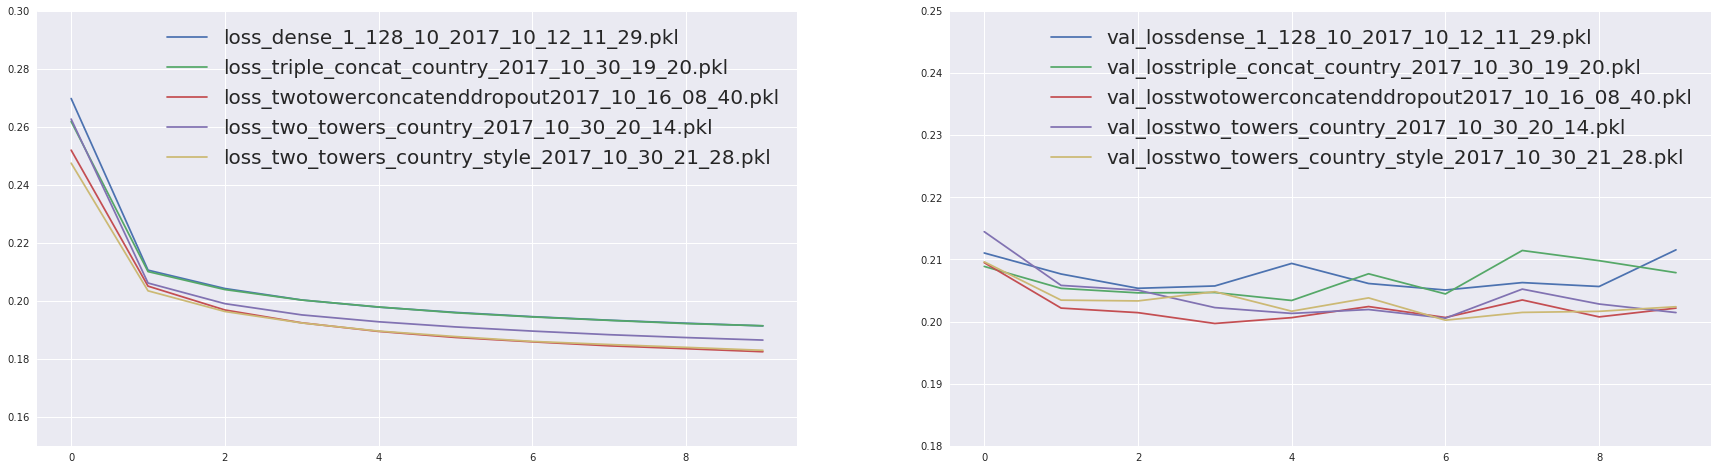

In [277]:
perf = {}
histories = [# our dense benchmark
             'dense_1_128_10_2017_10_12_11_29.pkl'
             # concat of 3 embeddings, beers users and beer country. Equivalent of the dense benchmark
             ,'triple_concat_country_2017_10_30_19_20.pkl'
             # tower benchmark
             , 'twotowerconcatenddropout2017_10_16_08_40.pkl'
             # two tower. One being user, the other being a dense(concat(beers,countries)) 
             ,'two_towers_country_2017_10_30_20_14.pkl'
             # adding the style of the beer. 
             ,'two_towers_country_style_2017_10_30_21_28.pkl'

            ]

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20)
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20)
        perf[val]=np.min(thepickle["val_loss"])
plt.subplot(121)
a = plt.ylim(0.15, 0.3)
plt.subplot(122)
a = plt.ylim(0.18, 0.25)

perf = pd.Series(perf)
perf.sort()
perf

Though adding information from the country seem to help a little the model without towers, it does not seem to be the case for the one with towers. 

We can continue adding metadata and grid search the architecture. To do so, we add also style, brewery and abv information for the beer, as well as location and gender of the user. 

Since the tower idea seemed to be the one to follow during my experiments. I choose to compare the following architectures:
- two towers: concat first information from the user on one side, from the item on the other side. Apply dense before concatenating again. 
- many to two towers: same idea except we add a dense to each embedding before concatenating them in either user or item tower.
- many towers: apply a dense on each embedding before concatenating them all (and apply dense). 


The keras code would look like

In [71]:
# user input
user_id_input = Input(shape=[1], name='user')
user_location_id_input = Input(shape=[1], name='user_location')
user_gender_id_input = Input(shape=[1], name='user_gender')
# beer input
item_id_input = Input(shape=[1], name='item')
country_id_input = Input(shape=[1], name='country')
style_id_input = Input(shape=[1], name='style')
brewery_id_input = Input(shape=[1], name='brewery')
abv_input = Input(shape=[1], name='abv')

# embedding sizes
embedding_user_size = 30
embedding_user_location_size = 30
embedding_user_gender_size = 30
embedding_beer_size = 30
embedding_country_size = 30 
embedding_style_size = 30
embedding_brewery_size = 30

# definition ogf the embeddings
user_embedding = Embedding(output_dim=embedding_user_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)

user_location_embedding = Embedding(output_dim=embedding_user_location_size, input_dim=user_locs.shape[0],
                           input_length=1, name='user_location_embedding')(user_location_id_input)

user_gender_embedding = Embedding(output_dim=embedding_user_gender_size, input_dim=users_genders.shape[0],
                           input_length=1, name='user_gender_embedding')(user_gender_id_input)

item_embedding = Embedding(output_dim=embedding_beer_size, input_dim=beers.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

country_embedding = Embedding(output_dim=embedding_country_size, input_dim=countries.shape[0],
                           input_length=1, name='country_embedding')(country_id_input)

style_embedding = Embedding(output_dim=embedding_style_size, input_dim=styles.shape[0],
                           input_length=1, name='style_embedding')(style_id_input)

brewery_embedding = Embedding(output_dim=embedding_brewery_size, input_dim=breweries.shape[0],
                           input_length=1, name='brewery_embedding')(brewery_id_input)

user_vecs = Reshape([embedding_user_size])(user_embedding)
location_vecs = Reshape([embedding_user_location_size])(user_location_embedding)
gender_vecs = Reshape([embedding_user_gender_size])(user_gender_embedding)
item_vecs = Reshape([embedding_beer_size])(item_embedding)
country_vecs = Reshape([embedding_country_size])(country_embedding)
style_vecs = Reshape([embedding_style_size])(style_embedding)
brewery_vecs = Reshape([embedding_brewery_size])(brewery_embedding)

# multi towers. Comment to drop the many tower idea.
user_vecs =  Dense(64, activation='relu')(user_vecs)
location_vecs =  Dense(64, activation='relu')(location_vecs)
gender_vecs =  Dense(64, activation='relu')(gender_vecs)
item_vecs =  Dense(64, activation='relu')(item_vecs)
style_vecs =  Dense(64, activation='relu')(style_vecs)
brewery_vecs = Dense(64, activation='relu')(brewery_vecs)

item_vecs_complete  = Concatenate()([item_vecs, country_vecs,style_vecs,brewery_vecs,abv_input])
# add dense for many to two towers idea? worse performance.
# item_vecs_complete = Dense(64, activation='relu')(item_vecs_complete)
# item_vecs_complete = Dropout(0.2)(item_vecs_complete) # add dropout ? worse performance

user_vecs_complete  = Concatenate()([user_vecs,location_vecs,gender_vecs])
# add dense for many to two towers idea? worse performance.
# user_vecs_complete = Dense(64, activation='relu')(user_vecs_complete) 
# user_vecs_complete = Dropout(0.2)(user_vecs_complete) # add dropout ? worse performance

# 2 steps concat. If dense above -> many to two. If no dense -> concat(concat) = concat -> many towers.
input_vecs = Concatenate()([user_vecs_complete, item_vecs_complete]) 
input_vecs = Dropout(0.2)(input_vecs)

x = Dense(128, activation='relu')(input_vecs)
x = Dropout(0.2)(x)

y = Dense(1)(x)
x = Dropout(0.2)(x)

model = Model(inputs=[user_id_input
                      , user_location_id_input
                      , user_gender_id_input
                      , item_id_input
                      , country_id_input,style_id_input
                      , brewery_id_input,abv_input], outputs=y)

model.compile(loss='mse',
              optimizer="adam"
             )

NameError: name 'user_locs' is not defined

The results are as follow.

manytwotowers64_emb30_allmetadata2017_11_02_11_36.pkl    0.196781
manytowers_allmetadata2017_10_31_17_41.pkl               0.197288
manytwotowers64_emb15_allmetadata2017_11_02_10_19.pkl    0.197533
manytwotowers64_allmetadata2017_11_01_10_16.pkl          0.197968
manytwotowers64_emb5_allmetadata2017_11_01_23_39.pkl     0.198597
twotowerconcatenddropout2017_10_16_08_40.pkl             0.199690
two_towers_allmetadata_2017_10_31_11_41.pkl              0.200161
two_towers_allbeermetadata_2017_10_31_08_56.pkl          0.200215
two_towers_country_style_2017_10_30_21_28.pkl            0.200216
manytotwotowers_allmetadata2017_11_01_08_10.pkl          0.202174
two_doubled_towers_allmetadata_2017_10_31_15_02.pkl      0.207450
two_towers_allmetadata_dropoutall2017_10_31_16_18.pkl    0.209830
dtype: float64

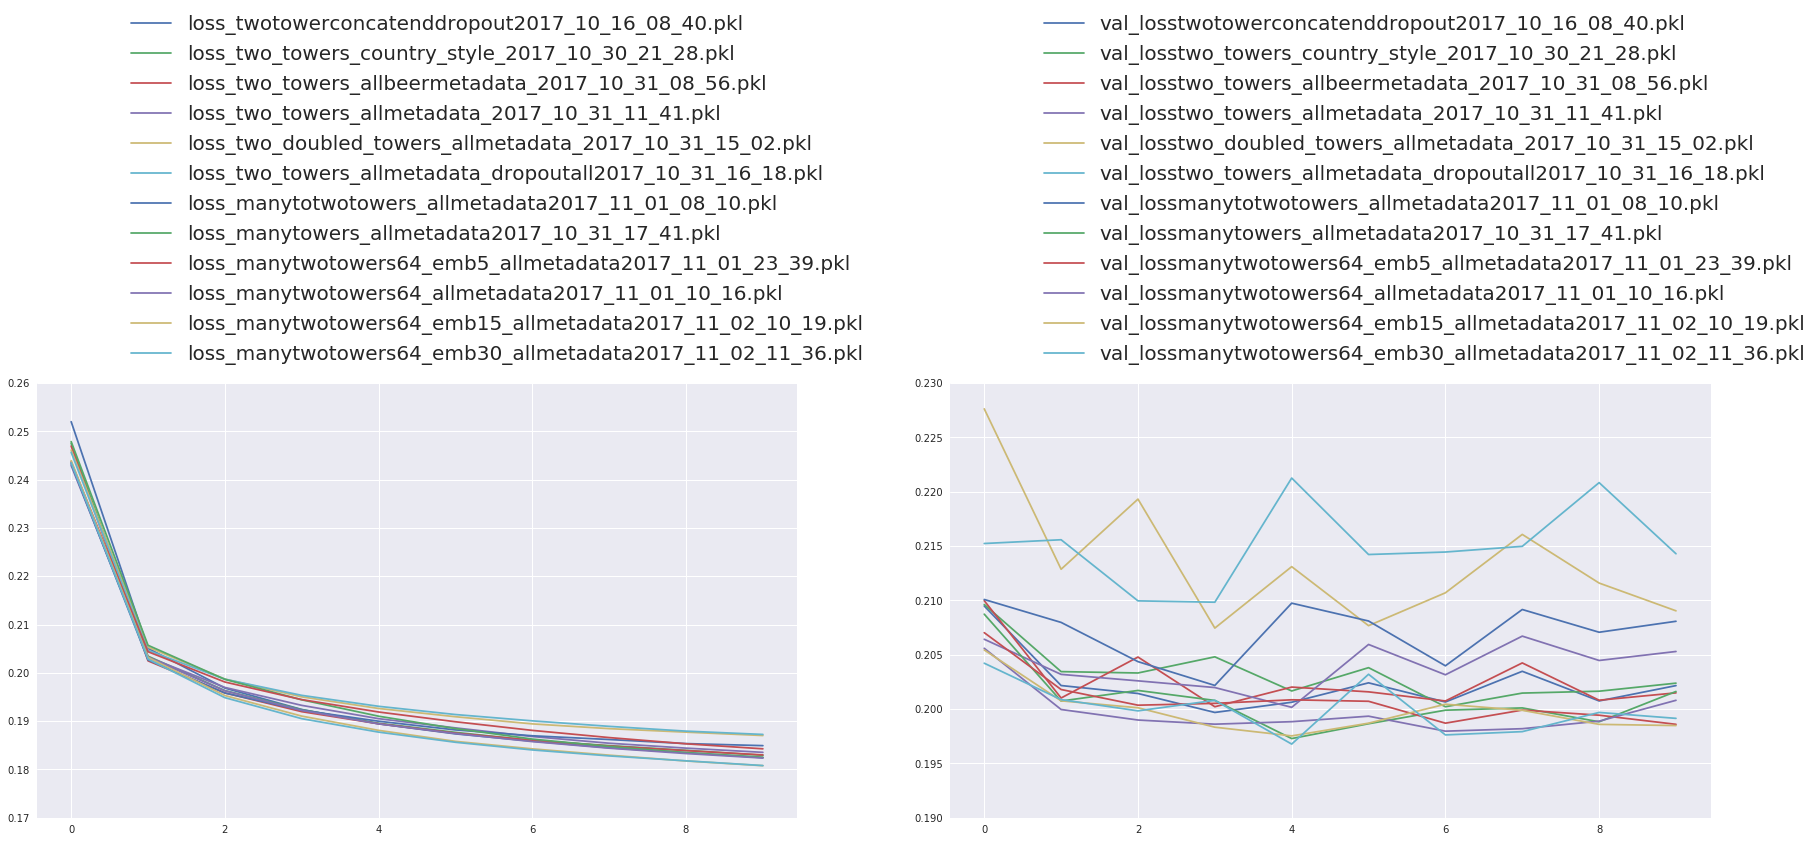

In [302]:
perf = {}
histories = [
        # tower benchmark
        'twotowerconcatenddropout2017_10_16_08_40.pkl'
        # two tower. One being user, the other being a dense(concat(beers,countries,style)) 
        ,'two_towers_country_style_2017_10_30_21_28.pkl'
        # two tower. One being user, the other being a dense(concat(beers,countries,style,brewery,abv)) 
        ,'two_towers_allbeermetadata_2017_10_31_08_56.pkl'
        # two tower. One being dense(concat((user, user location, use gender)))
        #         , the other being a dense(concat(beers,countries,style,brewery,abv))         
        ,'two_towers_allmetadata_2017_10_31_11_41.pkl'
        # two tower. One being dense(dense(concat((user, user location, use gender))))
        #         , the other being a dense(dense(concat(beers,countries,style,brewery,abv)))
        ,'two_doubled_towers_allmetadata_2017_10_31_15_02.pkl'
        # same as before with dropout on the towers dense layers
        ,'two_towers_allmetadata_dropoutall2017_10_31_16_18.pkl'
        # two towers, one for users, one for beers. 
        # Both towers are dense of concatenated dense towers of just the corresp embedding.
        ,'manytotwotowers_allmetadata2017_11_01_08_10.pkl'
        # one tower (dense 32) per embedding before concat. all embeddings of size 10.
        ,'manytowers_allmetadata2017_10_31_17_41.pkl'
        # one tower (dense 64) per embedding before concat. all embeddings of size 5.
        ,'manytwotowers64_emb5_allmetadata2017_11_01_23_39.pkl'
        # same with size 64
        ,'manytwotowers64_allmetadata2017_11_01_10_16.pkl'
        # same by getting a bigger embedding 
        ,'manytwotowers64_emb15_allmetadata2017_11_02_10_19.pkl'        
        # increasing size of embeddings to 30
        ,'manytwotowers64_emb30_allmetadata2017_11_02_11_36.pkl'
]

plt.figure(figsize=(30,8))
import pickle
mainpath = '/data.nfs/pgutierrez/beer_reco'
for val in histories:
    with open(mainpath + '/histories/' + val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.subplot(121)
        plot(thepickle["loss"][:10],label ='loss_' + val)
        plt.legend(fontsize=20,bbox_to_anchor=(0.1, 1))
        plt.subplot(122)
        plot(thepickle["val_loss"][:10],label='val_loss' + val)
        plt.legend(fontsize=20,bbox_to_anchor=(0.1, 1))
        perf[val]=np.min(thepickle["val_loss"])
plt.subplot(121)
a = plt.ylim(0.17, 0.26)
plt.subplot(122)
a = plt.ylim(0.19, 0.23)

perf = pd.Series(perf)
perf.sort()
perf


It seems that when we keep the same type of architecture, adding metadata do improve the performance a little. We are able to beat the basic concat benchmark with adding some metadata in the merge. The same way, we are able to beat the two tower strategy by adding one tower per input. 

Though at first it seemed that doing two towers; one for user, one for beer; made sense, it seems that concatenating using this strategy does not help improove our performance, with either two towers (concat all beer information and all user information) or many to two towers (apply dense for each embedding before creating the two towers). 

Dropout around the final layers seem to improove performance but it's not the case when adding it in the earlier ones.  

Note that all these performances are quite close. This means that it seems possible to overfit our target and that our current leaderboard might change when applying the models to the test set. Some models also seem unstable per epoch, adding to our final performance uncertainty.

By adding metadata we were able to gain some performance points. However this gain is way lower than what I expected. My current guess is that it's because we are framin the problem as a regression one. People will tend to only rate beer that they like, leading to low variation in user ratings. That's why I believe that taking into account implicit feedback would be really usefull. For example, from a person that rated one imperial IPA and 2 Imperial stout 4, we should be able to extract the fact that he does not like light beers because he never drank/rated one.  

Btw what is the best model ? 

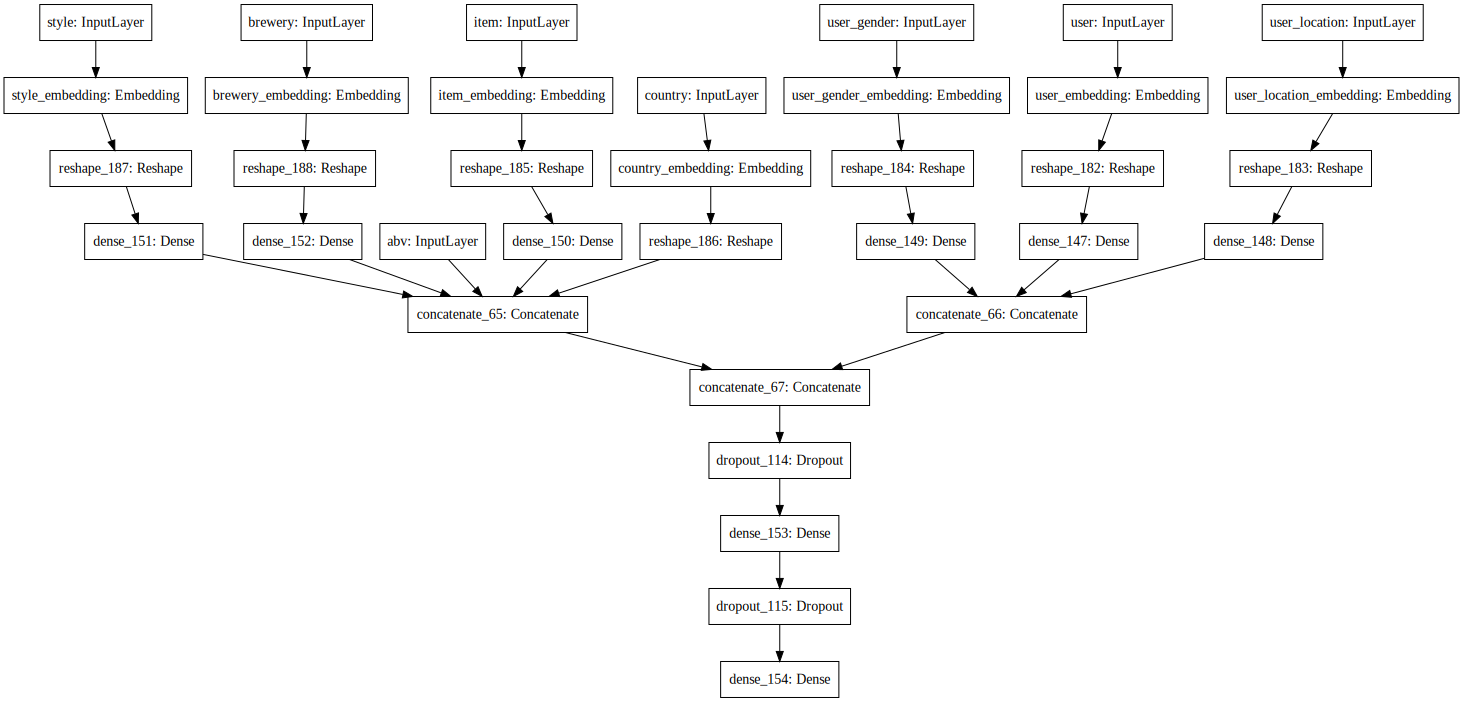

In [37]:
from keras.models import load_model
model = load_model('/data.nfs/pgutierrez/beer_reco/models/'+'manytwotowers64_emb30_allmetadata2017_11_02_11_36.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### A quick look at the embeddings 

Though the many to two towers is not the best performing model, it has the advantage of having intermediate embeddings (beers and users) containing metadata information that can be visualized. 

Below is the model architecture.

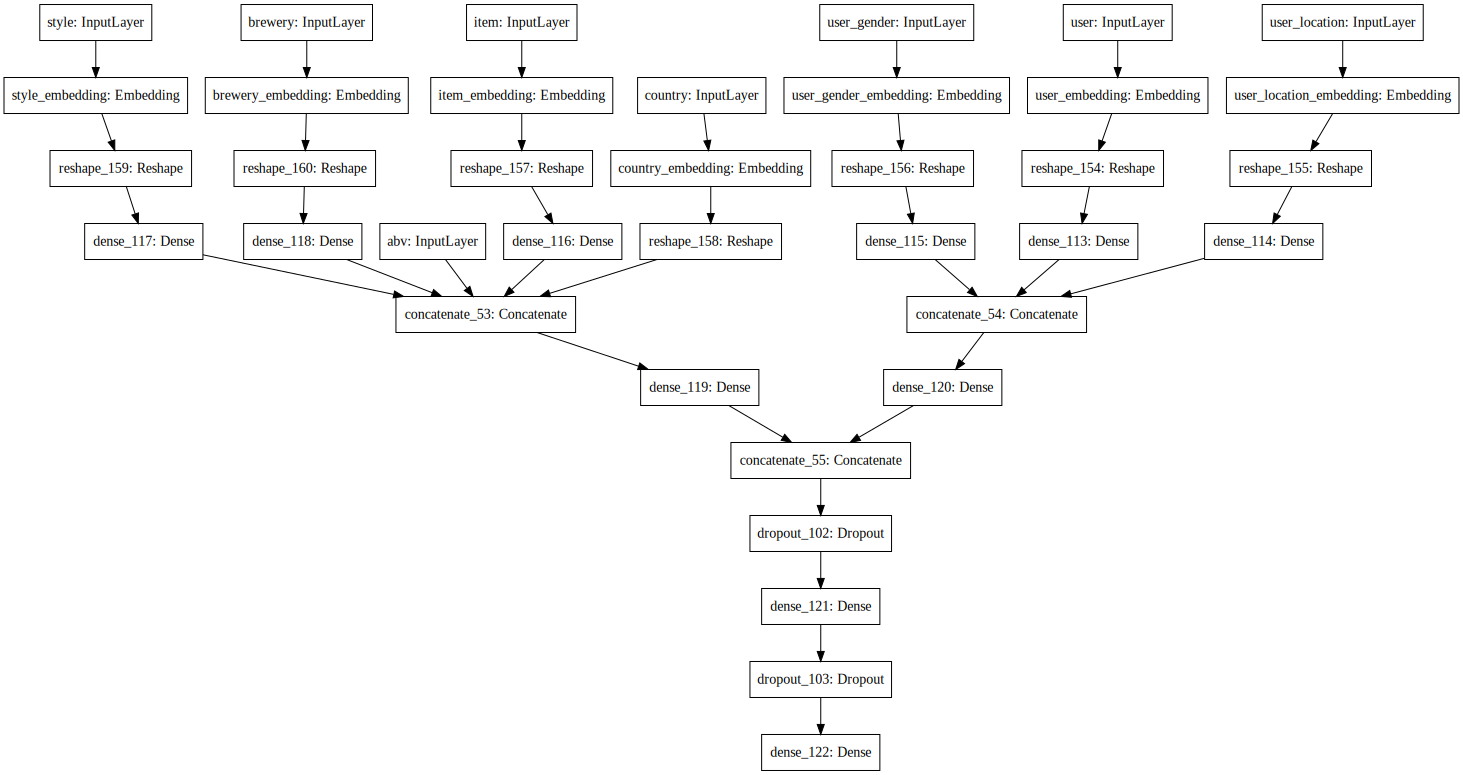

In [52]:
from keras.models import load_model
model = load_model('/data.nfs/pgutierrez/beer_reco/models/'+'manytotwotowers_allmetadata2017_11_01_08_10.h5')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

Let's start with the closest beer to Chimay.

In [130]:
from keras.models import load_model
model = load_model('/data.nfs/pgutierrez/beer_reco/models/'+'manytotwotowers_allmetadata2017_11_01_08_10.h5')

weights = model.get_weights()
user_embeddings = weights[0]
item_embeddings = weights[3]

similar1 = pd.DataFrame(most_similar(15782,item_embeddings,top_n=10,euclidian= False)
                        ,columns = ['Chimay emb bottom','Score'])

In [131]:
fakeusers = np.array([0]*78518)
thebeers = np.arange(len(beers))
layer_name = 'dense_119'
m2 = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
item_embeddings2 = m2.predict([fakeusers
                               , np.array([user2locs[x] for x in fakeusers]), np.array([user2genders[x] for x in fakeusers])
                               , thebeers, np.array([beer2countries[x] for x in thebeers]), np.array([beer2styles[x] for x in thebeers])
                               , np.array([beer2breweries[x] for x in thebeers]),np.array([beer2abv[x] for x in thebeers])]) # dirty dirty

similar2 = pd.DataFrame(most_similar(15782,item_embeddings2,top_n=10,euclidian= False)
                        ,columns = ['Chimay emb tower','Score'])


sim = pd.concat([similar1,similar2],axis=1)
sim

Chimay emb bottom     Score            Chimay emb tower     Score
0  Weihenstephaner Hefeweissbier Dunkel  0.990066  Embrasse                    0.999243
1  4th Anniversary Ale                   0.984302  St. Bernardus Tripel        0.998600
2  Provenance (Lemon & Lime)             0.983757  De Dolle Boskeun            0.998437
3  Haandbakk                             0.983572  Fantome De Tous Les Djapes  0.998435
4  The Dude's Bane                       0.981660  Achel Extra Blond           0.998360
5  Bedlam                                0.981001  Saison D'Erpe-Mere          0.998115
6  Founders Red's Rye IPA                0.980962  Embrasse Peated Oak Aged    0.998055
7  Double Bastard Ale                    0.980032  Red Rover                   0.997997
8  Scots Gone Wild                       0.978319  Fantôme Coffee Ruby         0.997871
9  Zeus Imperial IPA                     0.976920  Fuller's Vintage Ale        0.997702

Interestingly this time, the first list does not make much sense whereas some structure can be found in the second one (Belgium beers). This may be because the information that I consider structured like style or country is included in the style and country embeddings. As a result the beer embedding probably try to catch the additional information, which leads to non interpretable results.

It's difficult to find any structure directly in the embedding of the beer, perhaps for the reason mentioned above. However, we can find some in the dense layer created from the concatenation of the beer and its metadata embeddings. We can calculate a tsne representation of this layer. 

In [50]:
from sklearn.manifold import TSNE
smallembedding=item_embeddings[leastratedbeers]
%time item_tsne2 = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne2)
a.columns = ["x",'y']
a["beer_id"] = leastratedbeers
a['old_id'] = [beer_map[x] for x in leastratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_firstlevel_least_rated.csv")

from sklearn.manifold import TSNE
smallembedding=item_embeddings2[leastratedbeers]
%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = leastratedbeers
a['old_id'] = [beer_map[x] for x in leastratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_secondlevel_least rated.csv")


from sklearn.manifold import TSNE
smallembedding=item_embeddings2[mostratedbeers]
%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = mostratedbeers
a['old_id'] = [beer_map[x] for x in mostratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_secondlevel_most_rated.csv")

from sklearn.manifold import TSNE
smallembedding=item_embeddings[mostratedbeers]
%time item_tsne2 = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne2)
a.columns = ["x",'y']
a["beer_id"] = mostratedbeers
a['old_id'] = [beer_map[x] for x in mostratedbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_firstlevel_most_rated.csv")

from sklearn.manifold import TSNE
smallembedding=item_embeddings2[smallbeers]
%time item_tsne = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne)
a.columns = ["x",'y']
a["beer_id"] = smallbeers
a['old_id'] = [beer_map[x] for x in smallbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_secondlevel_random.csv")

from sklearn.manifold import TSNE
smallembedding=item_embeddings[smallbeers]
%time item_tsne2 = TSNE(perplexity=30).fit_transform(smallembedding)

a = pd.DataFrame(item_tsne2)
a.columns = ["x",'y']
a["beer_id"] = smallbeers
a['old_id'] = [beer_map[x] for x in smallbeers]
a.to_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_firstlevel_random.csv")

CPU times: user 2min 38s, sys: 52.5 s, total: 3min 30s
Wall time: 3min 32s


We are going to compare two tsne, once created on the most rated beers (displayed on the left) and one on the least rated beers (1 rating only, displayed on the right). 

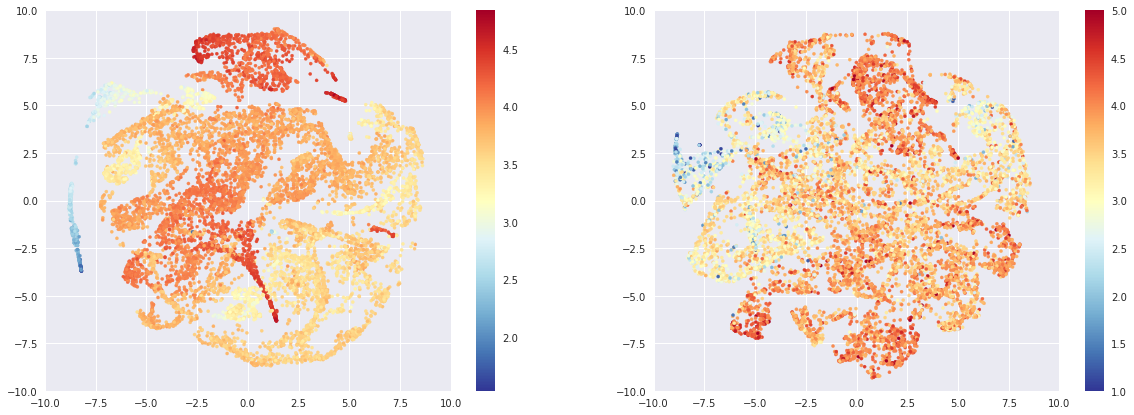

In [139]:
a = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_secondlevel_most_rated.csv")
b = pd.merge(a,all_info, how='left',left_on ='old_id', right_on = 'old_id') 
a2 = pd.read_csv("/data.nfs/pgutierrez/beer_reco/new_data/tsne_metadata_secondlevel.csv")
b2 =  pd.merge(a2,all_info, how='left',left_on ='old_id', right_on = 'old_id') 

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b2['x'], b2['y'],s=10,c= b2['avg_rating'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()


Let's discuss the graphs above. Note that since the embedding includes information from the abv, the style the country and the brewery, it is expected from the 2d dimensional map not to display perfect separations between all axes (abv, style,...).

When we display the average rating on the map, we see that both graphs exibit structure and that this structure is more explicit on the left side (beers with numerous ratings).

For the abv (bellow), the structure is clearer on the right side. Note that the abv is still correlated with average rating, and that beers with a lot of ratings are in general stronger. 


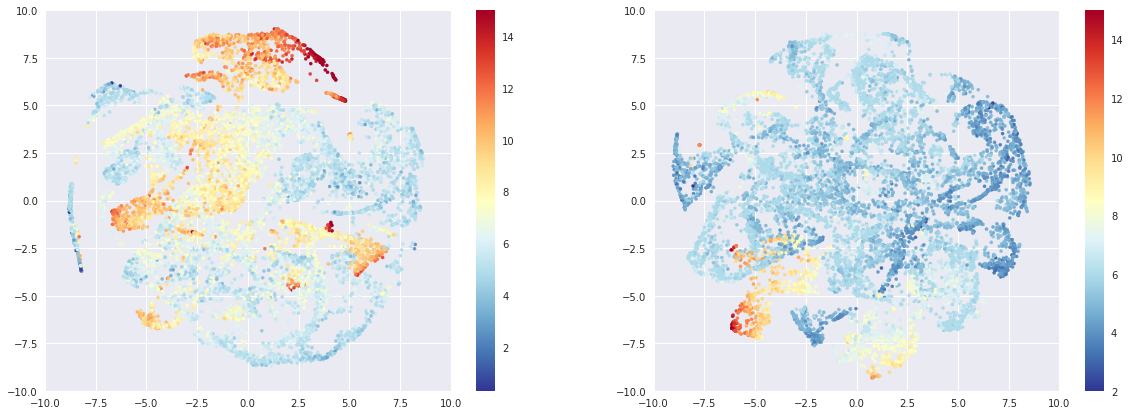

In [140]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= np.minimum(b['abv'],15),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.subplot(122)
sc = plt.scatter(b2['x'], b2['y'],s=10,c= np.minimum(b2['abv'],15),cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.colorbar(sc)

plt.show()


For the following map, we can see that there is variability in the country distribution. This is due to the fact that we have a large US user population. We can see more clusters on the right side, with English beers in blue and German in red. 

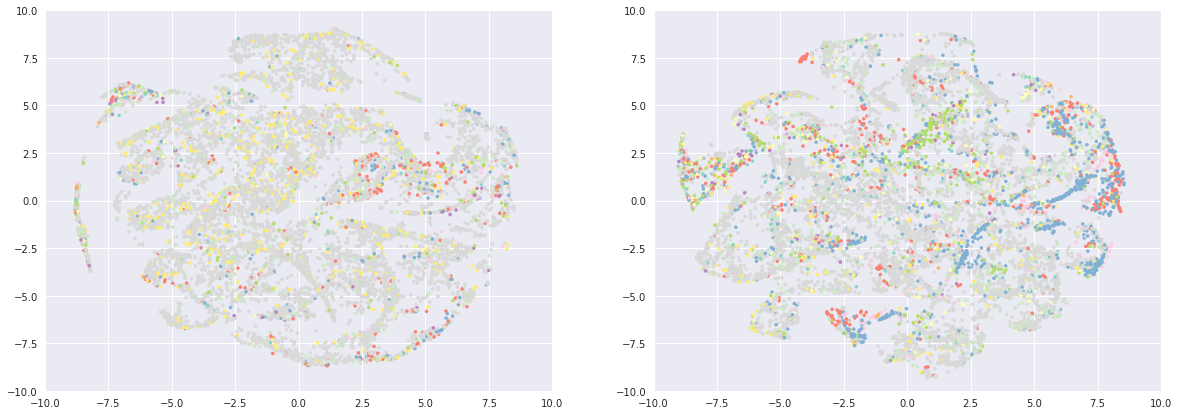

In [168]:
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

colorstyles = {style: sns.color_palette("Set3", len(countries))[i] for i,style in enumerate(countries)}

b['color_country'] = b['brewery_country'].map(colorstyles)
b2['color_country'] = b2['brewery_country'].map(colorstyles)

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['color_country'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(122)
sc = plt.scatter(b2['x'], b2['y'],s=10,c= b2['color_country'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()



To get a more precise idea, if we filter the beers to be from Germany or England we get: 

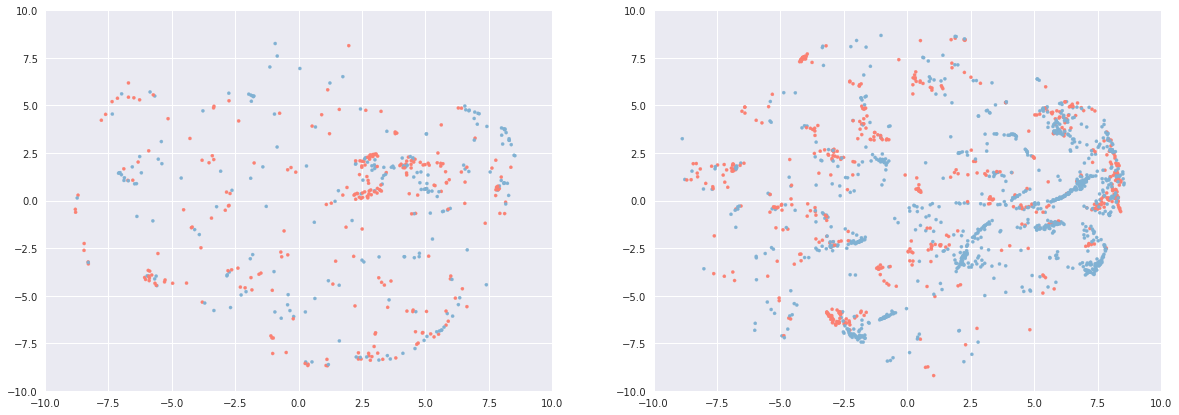

In [180]:
""" NO NEED TO DISPLAY THIS ONE"""

cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

colorstyles = {style: sns.color_palette("Set3", len(countries))[i] for i,style in enumerate(countries)}

b['color_country'] = b['brewery_country'].map(colorstyles)
b2['color_country'] = b2['brewery_country'].map(colorstyles)

c = b[(b['brewery_country']=='United Kingdom (England)' )|( b['brewery_country']=='Germany')]
c2 = b2[(b2['brewery_country']=='United Kingdom (England)')|( b2['brewery_country']=='Germany')]

plt.subplot(121)
sc = plt.scatter(c['x'], c['y'],s=10,c= c['color_country'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(122)
sc = plt.scatter(c2['x'], c2['y'],s=10,c= c2['color_country'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()



Which shows more clusters on the right sides. Remember that style, abv or breweries also play a role. This means that we will never have well defined large clusters. 

Finally, the style is more dominent in the right chart. We can see an orange and yellow cluster on the left made of Euro Pale lagger (think Heineken) and American Adjunct Lager (Think Budweiser). On the bottom, we have a yellow and grey cluster of German Pilsener (Beck's) English Pale Ale (London Pride). The bottom left is mostly imperial stout (see also the red region in the abv chart).

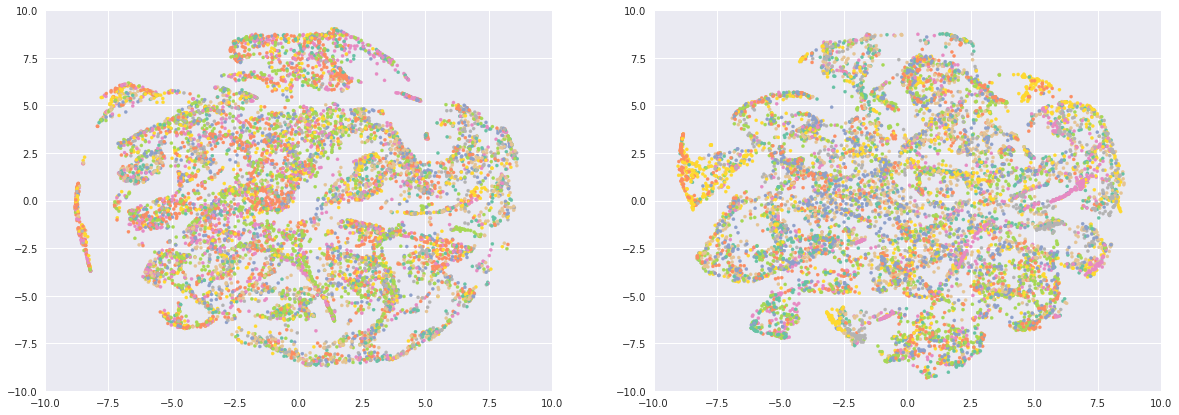

In [173]:
import seaborn as sns
cm = plt.cm.get_cmap('RdYlBu_r')
plt.figure(figsize=(20,7))

colorstyles = {style: sns.color_palette("Set2", len(styles))[i] for i,style in enumerate(styles)}

b['color_style'] = b['style'].map(colorstyles)
b2['color_style'] = b2['style'].map(colorstyles)

plt.subplot(121)
sc = plt.scatter(b['x'], b['y'],s=10,c= b['color_style'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.subplot(122)
sc = plt.scatter(b2['x'], b2['y'],s=10,c= b2['color_style'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

plt.show()


Some of these conclusions may be difficult for the reader to see, but I manually checked that I could not find pertinent clusters on the left side maps. 

To compare the two aproaches I also tried to predict the country based on the x and y coordinates. I kept only the top countries (USA, Canada, Australia, Englend, Belgium, Germany. The rest was grouped in "Others") and used a random forest. With the most rated beers, I got a MAUC of 0.646 and a best one class AUC (predict country vs the rest) of 0.681 for Belgium. For the least rated beers, I got a MAUC of 0.792 with one class AUC up to 0.863 for Germany or 0.923 for Australia.

I also did something similar for the style. I try to predict the presence of "stout" in the style. I got AUC of 0.722 for the popular beers and 0.778 for the beers rated only once. If we model the presence of "imperial stout", the gap is similar with AUCs of 0.882 and 0.928 respectively.

Bellow, I added my anotated map. 

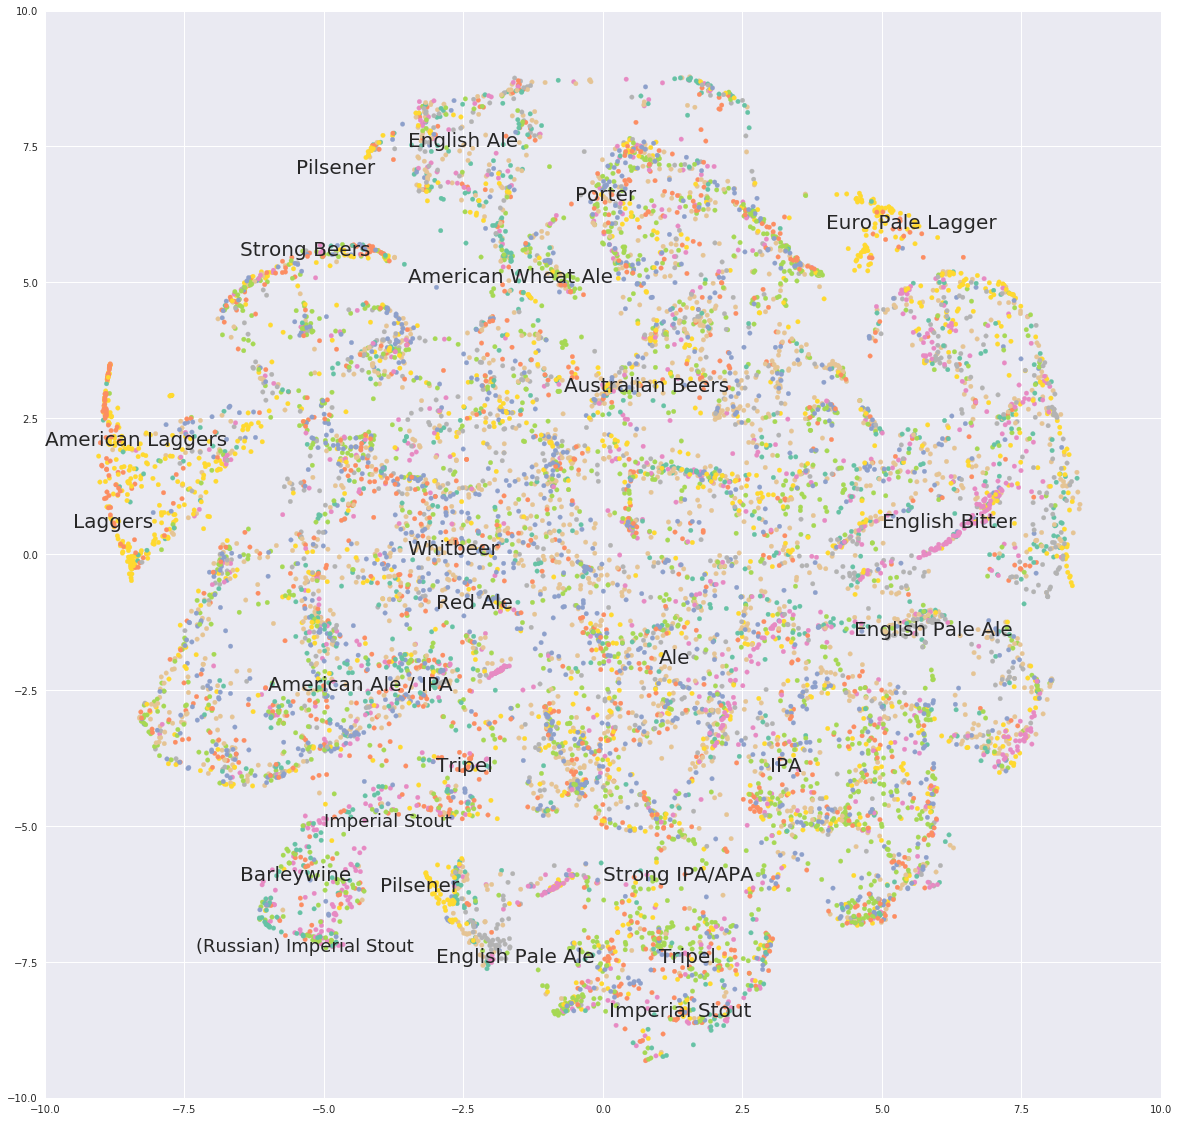

In [233]:
plt.figure(figsize=(20,20))
sc = plt.scatter(b2['x'], b2['y'],s=20,c= b2['color_style'],cmap=cm);
plt.xlim(-10, 10)
plt.ylim(-10, 10)

finalchart = plt.text(-10,2,'American Laggers',fontsize=20)
finalchart = plt.text(-9.5,0.5,'Laggers',fontsize=20)
finalchart = plt.text(-5,-5,'Imperial Stout',fontsize=18)
finalchart = plt.text(-7.3,-7.3,'(Russian) Imperial Stout',fontsize=18)
finalchart = plt.text(-4,-6.2,'Pilsener',fontsize=20)
finalchart = plt.text(-3,-7.5,'English Pale Ale',fontsize=20)
finalchart = plt.text(5,0.5,'English Bitter',fontsize=20)
finalchart = plt.text(4.5,-1.5,'English Pale Ale',fontsize=20)
finalchart = plt.text(0,-6,'Strong IPA/APA',fontsize=20)
finalchart = plt.text(0.1,-8.5,'Imperial Stout',fontsize=20)
finalchart = plt.text(-0.7,3,'Australian Beers',fontsize=20)
finalchart = plt.text(4,6,'Euro Pale Lagger',fontsize=20)
finalchart = plt.text(-3,-4,'Tripel',fontsize=20)
finalchart = plt.text(1,-7.5,'Tripel',fontsize=20)
finalchart = plt.text(-3.5,7.5,'English Ale',fontsize=20)
finalchart = plt.text(-5.5,7,'Pilsener',fontsize=20)
finalchart = plt.text(-0.5,6.5,'Porter',fontsize=20)
finalchart = plt.text(3,-4,'IPA',fontsize=20)
finalchart = plt.text(-6.5,5.5,'Strong Beers',fontsize=20)
finalchart = plt.text(-3,-1,'Red Ale',fontsize=20)
finalchart = plt.text(-3.5,5,'American Wheat Ale',fontsize=20)
finalchart = plt.text(-3.5,0,'Whitbeer',fontsize=20)
finalchart = plt.text(-6.5,-6,'Barleywine',fontsize=20)
finalchart = plt.text(-6,-2.5,'American Ale / IPA',fontsize=20)
finalchart = plt.text(1,-2,'Ale',fontsize=20)


This is a super interesting finding because it means the following:
- for heavily rated beers, the distance between two beers is mostly driven by how well they are rated. The style or country of the beer does not import much. 
- for beers that have only one rating, the distance is based way more on the metadata: abv, style, country (and probably brewery). 

This illustrates the phase transition from a content based recommendation engine (poor rating information, use of metadata) to a collaborative filtering one (use of the ratings only). This explains how deep learning architecture can perform well in different rating regimes, by creating its own mix between collaborative and content based approaches. 


### Verifying the performance on the test set.

The last thing to do is to check wether our grid search is reproducible on the test set. We get the following results:

In [265]:
# beer info
ratings_test["country_id"] = ratings_test["beer_id"].map(lambda x : beer2countries[x])
ratings_test["style_id"] = ratings_test["beer_id"].map(lambda x : beer2styles[x])
ratings_test["brewery_id"] = ratings_test["beer_id"].map(lambda x : beer2breweries[x])
ratings_test["abv"] = ratings_test["beer_id"].map(lambda x : beer2abv[x])
# scale abv
ratings_test["abv"] = scaler.transform(ratings_test["abv"].values)
# user info
ratings_test["location_id"] = ratings_test["user_id"].map(lambda x : user2locs.get(x,inverse_user_locs_map["no_data"])) # default no data
ratings_test["gender_id"] = ratings_test["user_id"].map(lambda x : user2genders.get(x,inverse_users_genders_map["no_data"]))    

In [273]:
from sklearn.metrics import mean_squared_error
load_path = "/data.nfs/pgutierrez/beer_reco/models/"
perfs = {}

mod = 'matrix_facto_10_2017_10_10_12_12.h5'
model = load_model(load_path+mod) 
ratings_test['preds_' + mod] = model.predict([ratings_test['user_id'],ratings_test['beer_id']])
perfs[mod] = mean_squared_error(ratings_test['score'], ratings_test['preds_'+mod])

models_nometa = [
                 # basic dense neural network
                'dense_1_128_10_2017_10_12_11_29.h5'
                 # two towers neural network
                ,'twotowerconcatenddropout2017_10_16_08_40.h5'
                ]
models_meta = [# many towers with metadata
            'manytwotowers64_emb30_allmetadata2017_11_02_11_36.h5'
            # many to two towers with metadata
            ,'manytotwotowers_allmetadata2017_11_01_08_10.h5'
            ]

for mod in models_nometa:
    model = load_model(load_path+mod)
    ratings_test['preds_' + mod] = model.predict([ratings_test['user_id'],ratings_test['beer_id']])
    perfs[mod] = mean_squared_error(ratings_test['score'], ratings_test['preds_'+mod])

for mod in models_meta:
    model = load_model(load_path+mod)
    ratings_test['preds_' + mod] = model.predict([ratings_test["user_id"].values
                                                 , ratings_test["location_id"].values
                                                 , ratings_test["gender_id"].values
                                                 , ratings_test["beer_id"].values
                                                 , ratings_test["country_id"].astype(int).values
                                                 , ratings_test["style_id"].astype(int).values
                                                 , ratings_test["brewery_id"].astype(int).values
                                                 , ratings_test["abv"].values])
    perfs[mod] = mean_squared_error(ratings_test['score'], ratings_test['preds_'+mod])
    

In [277]:
perfs= pd.Series(perfs)
perfs.sort()
perfs

manytwotowers64_emb30_allmetadata2017_11_02_11_36.h5    0.197776
twotowerconcatenddropout2017_10_16_08_40.h5             0.200793
manytotwotowers_allmetadata2017_11_01_08_10.h5          0.203316
dense_1_128_10_2017_10_12_11_29.h5                      0.206163
matrix_facto_10_2017_10_10_12_12.h5                     0.420949
dtype: float64

The good news is, our results are consistent and extremely stable.

# Conclusion

In this blog post we framed the recommendation engine as a regression machine learning problem. We demonstrated that using deep neural networks we can achieve better performance than using a matrix factorization matrix by dividing the MSE by 2. We explored the different architectures and showed that:
- concat layer is always better than multiply or dot.
- weirdly, creating separate dense layers on top of each embeddings before merging seems to bring performance
- going deeper (more than 3 layers) seems to lead to overfitting.

We also showed how to add metadata to the model, in order to cope with the cold start problem. It seems possible to increase performance, though the gain is not dramatic. 

Finally we explored the embeddings and found that:
- Checking closest neighboors make sense for the dot architecture, but this nice feature is lost when using deep neural networks. This seems to be because the network is able to create it's own distance, leading to poor intepretability. 
- When looking at tsne of the embeddings of models without metadata, we find that they merely correlate with any style our country, being driven mostly by ratings.  
- When checking the embeddings in a model with metadata, we found that the moidel seem to use the metadata more in a regime where the beer has few ratings information. 

Something we did not adress is the bias in ratings. Many people will tend to rate around 4 the beers they liked. This may leads to recommendations correlated to beer and user ratings average. But remember that we do not take into account the information that users do not rate beers they dislike. For example, let's say a person has drank 5 imperial stout and rated all of them near 4 stars. We can probably derive the information that he has not drank any coors light, because he does not like them. 

That's why, in a second post, we'll explore the implicit rating architecture, and try to combine both approaches.  

Stay tune for part 2!
